In [1]:
import awkward
import xgboost
import numpy as np
import os
import json
import awkward as ak
import coffea.util as util
#%pip install sklearn
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
from copy import deepcopy

import math
import correctionlib
import correctionlib.schemav2 as cs
import rich
from optparse import OptionParser

import hist

In [2]:
proc_dict = {
    "cH_4FS_FXFX_M125_2017": {
        "file": "input/merged_signals/cH_4FS_FXFX_M125_2017/NOMINAL/UNTAGGED_merged.parquet",
        "type": "signal",
        "coffea": "input/ch_signal.coffea",
        "label": 1.,
        "proc_id": 1,
    },
    "ggh_M125_2017": {
        "file": "input/merged_signals/ggh_M125_2017/NOMINAL/UNTAGGED_merged.parquet",
        # "file": "input/master-dev/ggh_M125_2017_UNTAGGED_merged.parquet",
        "type": "signal",
        "coffea": "input/signals.coffea",
        # "coffea": "input/master-dev/signals.coffea",
        "label": 1.,
        "proc_id": 2,
    },
    "tth_M125_2017": {
        "file": "input/merged_signals/tth_M125_2017/NOMINAL/UNTAGGED_merged.parquet",
        # "file": "input/master-dev/tth_M125_2017_UNTAGGED_merged.parquet",
        "type": "signal",
        "coffea": "input/signals.coffea",
        # "coffea": "input/master-dev/signals.coffea",
        "label": 1.,
        "proc_id": 3,
    },
    "vbf_M125_2017": {
        "file": "input/merged_signals/vbf_M125_2017/NOMINAL/UNTAGGED_merged.parquet",
        # "file": "input/master-dev/vbf_M125_2017_UNTAGGED_merged.parquet",
        "type": "signal",
        "coffea": "input/signals.coffea",
        # "coffea": "input/master-dev/signals.coffea",
        "label": 1.,
        "proc_id": 4,
    },
    "vh_M125_2017": {
        "file": "input/merged_signals/vh_M125_2017/NOMINAL/UNTAGGED_merged.parquet",
        # "file": "input/master-dev/vh_M125_2017_UNTAGGED_merged.parquet",
        "type": "signal",
        "coffea": "input/signals.coffea",
        # "coffea": "input/master-dev/signals.coffea",
        "label": 1.,
        "proc_id": 5,
    },
    "DiphotonBox_low_mass_M125_2017": {
        "file": "input/merged_backgrounds/DiphotonBox_low_mass_M125_2017/NOMINAL/UNTAGGED_merged.parquet",
        # "file": "input/master-dev/DiphotonBox_low_mass_M125_2017_UNTAGGED_merged.parquet",
        "type": "background",
        "coffea": "input/backgrounds_DiphotonBox_low_mass_M125.coffea",
        # "coffea": "input/master-dev/backgrounds.coffea",
        "label": 0.,
        "proc_id": -1,
    },
    "DiphotonBox_high_mass_M125_2017": {
        "file": "input/merged_backgrounds/DiphotonBox_high_mass_M125_2017/NOMINAL/UNTAGGED_merged.parquet",
        # "file": "input/master-dev/DiphotonBox_high_mass_M125_2017_UNTAGGED_merged.parquet",
        "type": "background",
        "coffea": "input/backgrounds_DiphotonBox_high_mass_M125.coffea",
        # "coffea": "input/master-dev/backgrounds.coffea",
        "label": 0.,
        "proc_id": -1,
    },
    "GJets_HT-40To100_M125_2017": {
        "file": "input/merged_backgrounds/GJets_HT-40To100_M125_2017/NOMINAL/UNTAGGED_merged.parquet",
        # "file": "input/master-dev/GJets_HT-40To100_M125_2017_UNTAGGED_merged.parquet",
        "type": "background",
        "coffea": "input/background_GJets_HT40To200_M125.coffea",
        # "coffea": "input/master-dev/backgrounds.coffea",
        "label": 0.,
        "proc_id": -2,
    },
    "GJets_HT-100To200_M125_2017": {
        "file": "input/merged_backgrounds/GJets_HT-100To200_M125_2017/NOMINAL/UNTAGGED_merged.parquet",
        # "file": "input/master-dev/GJets_HT-100To200_M125_2017_UNTAGGED_merged.parquet",
        "type": "background",
        "coffea": "input/background_GJets_HT40To200_M125.coffea",
        # "coffea": "input/master-dev/backgrounds.coffea",
        "label": 0.,
        "proc_id": -2,
    },
    "GJets_HT-200To400_M125_2017": {
        "file": "input/merged_backgrounds/GJets_HT-200To400_M125_2017/NOMINAL/UNTAGGED_merged.parquet",
        # "file": "input/master-dev/GJets_HT-200To400_M125_2017_UNTAGGED_merged.parquet",
        "type": "background",
        "coffea": "input/background_GJets_HT-200To400_M125.coffea",
        # "coffea": "input/master-dev/backgrounds.coffea",
        "label": 0.,
        "proc_id": -2,
    },
    "GJets_HT-400To600_M125_2017": {
        "file": "input/merged_backgrounds/GJets_HT-400To600_M125_2017/NOMINAL/UNTAGGED_merged.parquet",
        # "file": "input/master-dev/GJets_HT-400To600_M125_2017_UNTAGGED_merged.parquet",
        "type": "background",
        "coffea": "input/background_GJets_HT-400To600_M125.coffea",
        # "coffea": "input/master-dev/backgrounds.coffea",
        "label": 0.,
        "proc_id": -2,
    },
    "QCD_M125_2017": {
        "file": "input/merged_backgrounds/QCD_M125_2017_syst_2/NOMINAL/UNTAGGED_merged.parquet",
        #"file": "/work/bevila_t/HpC_Analysis/HiggsDNA/coffea/myfork/dev-master/higgs-dna-tiziano-bevilacqua/scripts/out_dir_eta_290623/merged/QCD_M125_2017/nominal/UNTAGGED_merged.parquet",
        #"file": "input/master-dev/QCD_M125_2017_UNTAGGED_merged.parquet",
        "type": "background",
        "coffea": "input/merged_backgrounds/QCD_M125_2017_syst_2/background_QCD_M125.coffea",
        #"coffea": "/work/bevila_t/HpC_Analysis/HiggsDNA/coffea/myfork/dev-master/higgs-dna-tiziano-bevilacqua/scripts/out_dir_eta_290623/backgrounds.coffea",
        # "coffea": "input/master-dev/QCD_M125_2017_backgrounds.coffea",
        "label": 0.,
        "proc_id": -3,
    },
    #"Data_2017": {
    #    "file": "input/master-dev/allData_UNTAGGED_merged.parquet",
    #    "type": "data",
    #    # "coffea": "input/data.coffea",
    #    "coffea": "input/master-dev/data.coffea",
    #    "label": -1.,
    #    "proc_id": 0,
    #},
    "DoubleEG_B_2017": {
        "file": "input/merged_data/DoubleEG_B_2017_UNTAGGED_merged.parquet",
        # "file": "input/master-dev/DoubleEG_B_2017_UNTAGGED_merged.parquet",
        "type": "data",
        # "coffea": "input/data.coffea",
        "coffea": "input/master-dev/data.coffea",
        "label": -1.,
        "proc_id": 0,
    },
    "DoubleEG_C_2017": {
        "file": "input/merged_data/DoubleEG_C_2017_UNTAGGED_merged.parquet",
        # "file": "input/master-dev/DoubleEG_C_2017_UNTAGGED_merged.parquet",
        "type": "data",
        # "coffea": "input/data.coffea",
        "coffea": "input/data.coffea",
        "label": -1.,
        "proc_id": 0,
    },
    "DoubleEG_D_2017": {
        "file": "input/merged_data/DoubleEG_D_2017_UNTAGGED_merged.parquet",
        # "file": "input/master-dev/DoubleEG_D_2017_UNTAGGED_merged.parquet",
        "type": "data",
        # "coffea": "input/data.coffea",
        "coffea": "input/master-dev/data.coffea",
        "label": -1.,
        "proc_id": 0,
    },
    "DoubleEG_E_2017": {
        "file": "input/merged_data/DoubleEG_E_2017_UNTAGGED_merged.parquet",
        # "file": "input/master-dev/DoubleEG_E_2017_UNTAGGED_merged.parquet",
        "type": "data",
        # "coffea": "input/data.coffea",
        "coffea": "input/master-dev/data.coffea",
        "label": -1.,
        "proc_id": 0,
    },
    "DoubleEG_F_2017": {
        "file": "input/merged_data/DoubleEG_F_2017_UNTAGGED_merged.parquet",
        # "file": "input/master-dev/DoubleEG_F_2017_UNTAGGED_merged.parquet",
        "type": "data",
        # "coffea": "input/data.coffea",
        "coffea": "input/master-dev/data.coffea",
        "label": -1.,
        "proc_id": 0,
    },
}

In [3]:
# concatenate the MC and Data events (separately) and add normalisation

In [4]:
with open(
        "/work/bevila_t/HpC_Analysis/HiggsDNA/coffea/myfork/dev/higgs-dna-tiziano-bevilacqua/higgs_dna/metaconditions/cross_sections.json", "r"
    ) as pf:
        XSs = json.load(pf)

In [5]:
sig_coffea = util.load("input/master-dev/signals.coffea")
bkg_coffea = util.load("input/master-dev/backgrounds.coffea")
data_coffea = util.load("input/master-dev/data.coffea")
qcd_coffea = util.load("input/merged_backgrounds/QCD_M125_2017_syst_2/background_QCD_M125.coffea")


In [6]:
util.load("input/data.coffea")

{'histos': {},
 'weight_sum': {'ch': 0.0,
  'ggh': 0.0,
  'tth': 0.0,
  'vbf': 0.0,
  'vh': 0.0,
  'nr_gg_low': 0.0,
  'nr_gg_high': 0.0,
  'gjets': 0.0,
  'dy': 0.0,
  'qcd': 0.0,
  'data': 265859299.0},
 'norm_1fb': {'data': 5315},
 'sel_events': {'nominal': {'data': 2228246.0}},
 'tot_events': 265859299.0}

In [7]:
sig_events = []
bkg_events = []
data_events = []

# columns = ['weight', 'centralObjectWeight', 'bdt_score', 'dZ', 'CMS_hgg_mass', 'event', 'pt', 'eta', 'phi', 'n_jets', 'lead_jet_pt', 'lead_jet_eta', 'lead_jet_phi', 'lead_jet_mass', 'lead_jet_PN_CvL', 'lead_jet_PN_CvB', 'lead_jet_PN_B', 'lead_jet_btagDeepFlav_B', 'lead_jet_btagDeepFlav_CvB', 'lead_jet_btagDeepFlav_CvL', 'lead_jet_btagDeepFlav_QG', 'LeadPhoton_pt_mgg', 'LeadPhoton_eta', 'LeadPhoton_phi', 'LeadPhoton_mvaID', 'SubleadPhoton_pt_mgg', 'SubleadPhoton_eta', 'SubleadPhoton_phi', 'SubleadPhoton_mvaID', 'Diphoton_cos_dPhi', 'sigmaMrv', 'sigmaMwv', 'PV_score', 'PV_chi2', 'nPV', 'dZ_1', 'dZ_2', 'dZ_3']
columns = ['weight', 'dZ', 'CMS_hgg_mass', 'event', 'pt', 'eta', 'phi', 'LeadPhoton_pt_mgg', 'LeadPhoton_eta', 'LeadPhoton_phi', 'LeadPhoton_mvaID', 'SubleadPhoton_pt_mgg', 'SubleadPhoton_eta', 'SubleadPhoton_phi', 'SubleadPhoton_mvaID', 'Diphoton_cos_dPhi', 'sigmaMrv', 'sigmaMwv', 'PV_score', 'PV_chi2', 'nPV', 'dZ_1', 'dZ_2', 'dZ_3']
               
for i, dataset in enumerate(proc_dict):
    meta = util.load(proc_dict[dataset]["coffea"])
    if dataset == "QCD_M125_2017":
        # QCD is not added to the MC set of events
        print(dataset, ":)")
        norm = XSs[dataset]["xs"] * XSs[dataset]["bf"] * XSs["lumi"]["2017"] / meta["weight_sum"][XSs[dataset]["name"]]  * 1000
        qcd_events = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
        qcd_events["weight"] = qcd_events["weight"] * norm
        qcd_events["proc_id"] = ak.ones_like(qcd_events["weight"]) * proc_dict[dataset]["proc_id"]
        continue
    print(dataset)
    if proc_dict[dataset]["type"] == "signal":
        norm = XSs[dataset]["xs"] * XSs[dataset]["bf"] * XSs["lumi"]["2017"] / meta["weight_sum"][XSs[dataset]["name"]] * 1000
        proc_dict[dataset]["norm"] = norm
        if len(sig_events) == 0:
            sig_events = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            sig_events["weight"] = sig_events["weight"] * norm
            sig_events["proc_id"] = ak.ones_like(sig_events["weight"]) * proc_dict[dataset]["proc_id"]
        else:
            tmp_ = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            tmp_["weight"] = tmp_["weight"] * norm
            tmp_["proc_id"] = ak.ones_like(tmp_["weight"]) * proc_dict[dataset]["proc_id"]
            sig_events = ak.concatenate([sig_events, tmp_])
    
    elif proc_dict[dataset]["type"] == "background":
        norm = XSs[dataset]["xs"] * XSs[dataset]["bf"] * XSs["lumi"]["2017"] / meta["weight_sum"][XSs[dataset]["name"]]  * 1000
        proc_dict[dataset]["norm"] = norm
        if len(bkg_events) == 0:
            bkg_events = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            bkg_events["weight"] = bkg_events["weight"] * norm
            bkg_events["proc_id"] = ak.ones_like(bkg_events["weight"]) * proc_dict[dataset]["proc_id"]
        else:
            tmp_ = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            tmp_["weight"] = tmp_["weight"] * norm
            tmp_["proc_id"] = ak.ones_like(tmp_["weight"]) * proc_dict[dataset]["proc_id"]
            bkg_events = ak.concatenate([bkg_events, tmp_])
    
    elif proc_dict[dataset]["type"] == "data":
        if len(data_events) == 0:
            data_events = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            data_events["proc_id"] = ak.ones_like(data_events["weight"]) * proc_dict[dataset]["proc_id"]
        else:
            tmp_ = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            tmp_["proc_id"] = ak.ones_like(tmp_["weight"]) * proc_dict[dataset]["proc_id"]
            data_events = ak.concatenate([data_events, tmp_])

sig_events["label"] = ak.ones_like(sig_events["weight"])
bkg_events["label"] = ak.zeros_like(bkg_events["weight"])
data_events["label"] = ak.ones_like(data_events["weight"]) * -1.

cH_4FS_FXFX_M125_2017
ggh_M125_2017
tth_M125_2017
vbf_M125_2017
vh_M125_2017
DiphotonBox_low_mass_M125_2017
DiphotonBox_high_mass_M125_2017
GJets_HT-40To100_M125_2017
GJets_HT-100To200_M125_2017
GJets_HT-200To400_M125_2017
GJets_HT-400To600_M125_2017
QCD_M125_2017 :)
DoubleEG_B_2017
DoubleEG_C_2017
DoubleEG_D_2017
DoubleEG_E_2017
DoubleEG_F_2017


In [8]:
# read old qcd from samuel may's higgsdna
events = []
events = awkward.from_parquet("test_Data_2017_photon_cleaning/merged_nominal.parquet") 
events = awkward.values_astype(events, np.float64)
data   = events[events.process_id==0]
events = events[events.process_id>0]

qcd = events[(events.process_id == 7)]# & (abs(events.LeadPhoton_eta) <= 2.3) & (abs(events.SubleadPhoton_eta) <= 2.3)]
norm = ak.sum(qcd_events.weight) / ak.sum(qcd["weight_central"])
qcd["weight"] = qcd["weight_central"] * norm
qcd["square_weight"] = qcd["weight"] ** 2
qcd["CMS_hgg_mass"] = qcd["Diphoton_mass"]
qcd["pt"] = qcd["Diphoton_pt"]
qcd["eta"] = qcd["Diphoton_eta"]
qcd["phi"] = qcd["Diphoton_phi"]
qcd["dZ"] = ak.zeros_like(qcd["Diphoton_pt"])
qcd = qcd[columns]
qcd["label"] = ak.zeros_like(qcd["weight"])
qcd["proc_id"] = ak.ones_like(qcd["weight"]) * proc_dict["QCD_M125_2017"]["proc_id"]
print(qcd.fields)
bkg_events = ak.concatenate([bkg_events, qcd])

['weight', 'dZ', 'CMS_hgg_mass', 'event', 'pt', 'eta', 'phi', 'LeadPhoton_pt_mgg', 'LeadPhoton_eta', 'LeadPhoton_phi', 'LeadPhoton_mvaID', 'SubleadPhoton_pt_mgg', 'SubleadPhoton_eta', 'SubleadPhoton_phi', 'SubleadPhoton_mvaID', 'Diphoton_cos_dPhi', 'sigmaMrv', 'sigmaMwv', 'PV_score', 'PV_chi2', 'nPV', 'dZ_1', 'dZ_2', 'dZ_3', 'label', 'proc_id']


In [9]:
MC_events = ak.concatenate([sig_events, bkg_events])

# add VtxProbability 
MC_events["vtxProb"] = 2 * MC_events["sigmaMrv"] / (MC_events["sigmaMrv"] + MC_events["sigmaMwv"])
data_events["vtxProb"] = 2 * data_events["sigmaMrv"] / (data_events["sigmaMrv"] + data_events["sigmaMwv"])
MC_events = ak.values_astype(MC_events, np.float64)
data_events = ak.values_astype(data_events, np.float64)
# MC_events.fields

In [10]:
ak.sum(sig_events.weight[sig_events.proc_id==1])

3.872329277786899

In [11]:
MC_events_zero = deepcopy(MC_events)
MC_events_zero["weight"] = ak.where(
    MC_events.weight > 0,
    MC_events.weight,
    MC_events.weight * 0.
)

MC_events_abs = deepcopy(MC_events)
MC_events_abs["weight"] = abs(MC_events_abs["weight"])

MC_events["square_weight"] = MC_events["weight"] ** 2
MC_events_zero["square_weight"] = MC_events_zero["weight"] ** 2
MC_events_abs["square_weight"] = MC_events_abs["weight"] ** 2

# Signals lead and sublead pt/mgg

In [12]:
# cuts for mask in the plots 
signal_cut = (MC_events.proc_id > 0)

In [13]:
colors = ["red", "blue", "green"]

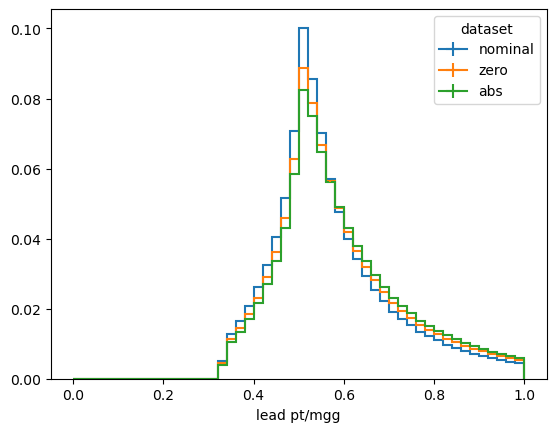

In [15]:
min_ = 0.
max_ = 1
nbins = 50
var = "LeadPhoton_pt_mgg"
var2 = "SubleadPhoton_pt_mgg"

dists = (
    hist.Hist.new
    .StrCat(["nominal", "zero", "abs"], name="dataset", growth=True)
    .Reg(bins=nbins, start=min_, stop=max_, name="lead", label="lead pt/mgg")
    .Reg(bins=nbins, start=min_, stop=max_, name="sublead", label="sublead pt/mgg")
    .Weight()
    .fill(
        dataset="nominal",
        lead=MC_events[var][signal_cut],
        sublead=MC_events[var2][signal_cut],
        weight=MC_events.weight[signal_cut]/sum(MC_events.weight[signal_cut])
    )
    .fill(
        dataset="zero",
        lead=MC_events_zero[var][signal_cut],
        sublead=MC_events_zero[var2][signal_cut],
        weight=MC_events_zero.weight[signal_cut]/sum(MC_events_zero.weight[signal_cut])
    )
    .fill(
        dataset="abs",
        lead=MC_events[var][signal_cut],
        sublead=MC_events[var2][signal_cut],
        weight=abs(MC_events.weight[signal_cut])/sum(abs(MC_events.weight[signal_cut]))
    )
)

fig, ax = plt.subplots()
dists[:, :, sum].plot1d(ax=ax)
ax.legend(title="dataset")

/tmp/ipykernel_10627/1533703701.py:5: RuntimeWarning: invalid value encountered in true_divide
  num / den,


ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f5db00bc9d0>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f5db008fa00>, text=[])

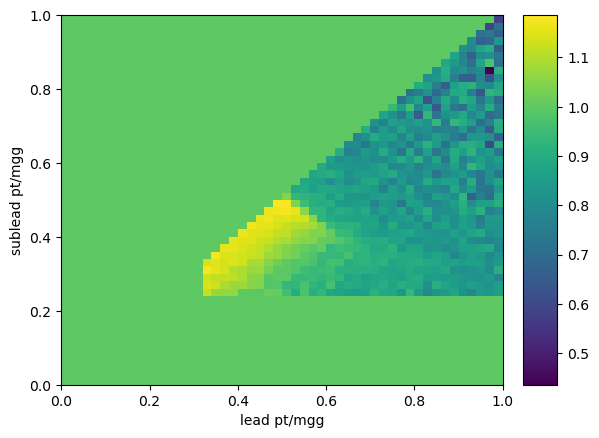

In [16]:
num = dists["nominal", :, :].values()
den = dists["zero", :, :].values()
sf = np.where(
    (num > 0) & (den > 0),
    num / den,
    1.0,
)

# a quick way to plot the scale factor is to steal the axis definitions from the input histograms:
sfhist = hist.Hist(*dists.axes[1:], data=sf)
sfhist.plot2d()



/tmp/ipykernel_10627/2498145880.py:5: RuntimeWarning: invalid value encountered in true_divide
  num / den,


ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f5d98585420>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f5d985857e0>, text=[])

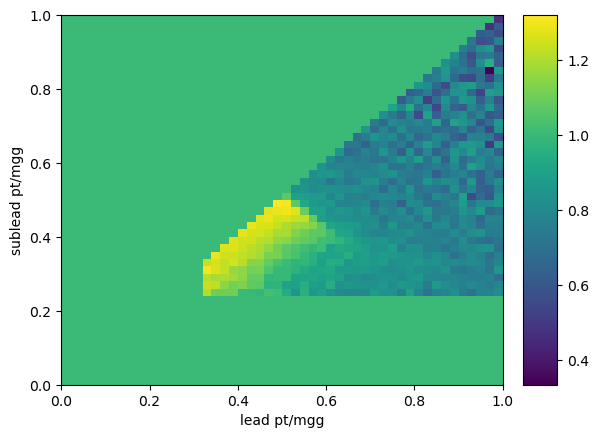

In [17]:
num = dists["nominal", :, :].values()
den = dists["abs", :, :].values()
sf_abs = np.where(
    (num > 0) & (den > 0),
    num / den,
    1.0,
)

# a quick way to plot the scale factor is to steal the axis definitions from the input histograms:
sfhist_abs = hist.Hist(*dists.axes[1:], data=sf_abs)
sfhist_abs.plot2d()

In [18]:
import correctionlib.convert

# without a name, the resulting object will fail validation
sfhist.name = "zero_to_nominal"
sfhist.label = "reweighted"
zero_to_nominal = correctionlib.convert.from_histogram(sfhist)
zero_to_nominal.description = "Reweights zero wgt to agree with nominal"
# set overflow bins behavior (default is to raise an error when out of bounds)
zero_to_nominal.data.flow = "clamp"
rich.print(zero_to_nominal)

📈 zero_to_nominal (v0)
Reweights zero wgt to agree with nominal
Node counts: MultiBinning: 1
╭─────────── ▶ input ────────────╮ ╭─────────── ▶ input ────────────╮
│ lead (real)                    │ │ sublead (real)                 │
│ lead pt/mgg                    │ │ sublead pt/mgg                 │
│ Range: [0.0, 1.0), overflow ok │ │ Range: [0.0, 1.0), overflow ok │
╰────────────────────────────────╯ ╰────────────────────────────────╯
╭──── ◀ output ─────╮
│ reweighted (real) │
│ No description    │
╰───────────────────╯

In [19]:
# without a name, the resulting object will fail validation
sfhist_abs.name = "abs_to_nominal"
sfhist_abs.label = "reweighted"
abs_to_nominal = correctionlib.convert.from_histogram(sfhist_abs)
abs_to_nominal.description = "Reweights zero wgt to agree with nominal"
# set overflow bins behavior (default is to raise an error when out of bounds)
abs_to_nominal.data.flow = "clamp"
rich.print(abs_to_nominal)

📈 abs_to_nominal (v0)
Reweights zero wgt to agree with nominal
Node counts: MultiBinning: 1
╭─────────── ▶ input ────────────╮ ╭─────────── ▶ input ────────────╮
│ lead (real)                    │ │ sublead (real)                 │
│ lead pt/mgg                    │ │ sublead pt/mgg                 │
│ Range: [0.0, 1.0), overflow ok │ │ Range: [0.0, 1.0), overflow ok │
╰────────────────────────────────╯ ╰────────────────────────────────╯
╭──── ◀ output ─────╮
│ reweighted (real) │
│ No description    │
╰───────────────────╯

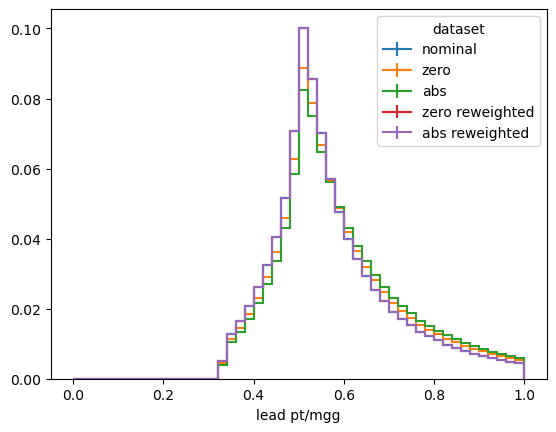

In [20]:
dists.fill(
    dataset="zero reweighted",
    lead=MC_events_zero[var][signal_cut],
    sublead=MC_events_zero[var2][signal_cut],
    weight=MC_events_zero.weight[signal_cut]/sum(MC_events_zero.weight[signal_cut])*zero_to_nominal.to_evaluator().evaluate(MC_events_zero[var][signal_cut], MC_events_zero[var2][signal_cut])
)
dists.fill(
    dataset="abs reweighted",
    lead=MC_events[var][signal_cut],
    sublead=MC_events[var2][signal_cut],
    weight=abs(MC_events.weight[signal_cut])/sum(abs(MC_events.weight[signal_cut]))*abs_to_nominal.to_evaluator().evaluate(MC_events[var][signal_cut], MC_events[var2][signal_cut])
)

fig, ax = plt.subplots()
dists[:, :, sum].plot1d(ax=ax)
ax.legend(title="dataset")

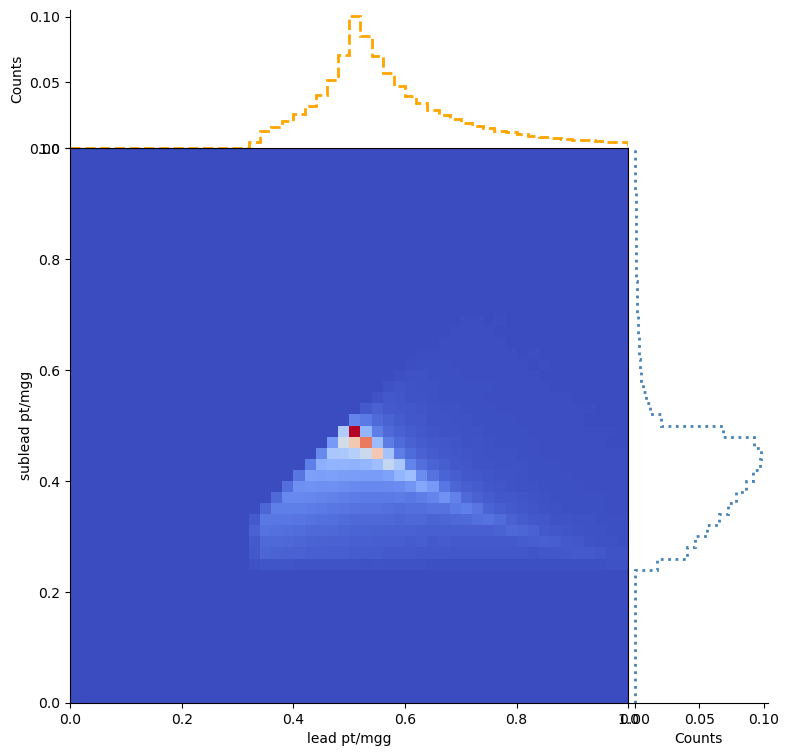

In [45]:
fig = plt.figure(figsize=(9, 9))

var = "LeadPhoton_pt_mgg"
var2 = "SubleadPhoton_pt_mgg"
min_ = 0.
max_ = 1
nbins = 50

h = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "lead", label="lead pt/mgg"), hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "sublead", label="sublead pt/mgg"))
h_zero_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "lead", label="lead pt/mgg"), hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "sublead", label="sublead pt/mgg"))
h_abs_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "lead", label="lead pt/mgg"), hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "sublead", label="sublead pt/mgg"))

h.fill(lead = MC_events[var][signal_cut], sublead = MC_events[var2][signal_cut], weight = MC_events.weight[signal_cut]/sum(MC_events.weight[signal_cut]))
h_zero_wgt.fill(lead = MC_events_zero[var][signal_cut], sublead = MC_events[var2][signal_cut], weight = MC_events_zero.weight[signal_cut]/sum(MC_events_zero.weight[signal_cut]))
h_abs_wgt.fill(lead = MC_events_abs[var][signal_cut], sublead = MC_events[var2][signal_cut], weight = abs(MC_events_abs.weight[signal_cut])/sum(MC_events_abs.weight[signal_cut]))

# plot2d_full
h.plot2d_full(
    main_cmap="coolwarm",
    top_ls="--",
    top_color="orange",
    top_lw=2,
    side_ls=":",
    side_lw=2,
    side_color="steelblue",
)

plt.show()


/tmp/ipykernel_32925/781255448.py:53: RuntimeWarning: invalid value encountered in true_divide
  mc["bins"][hist_] / mc["bins"]["nominal"],


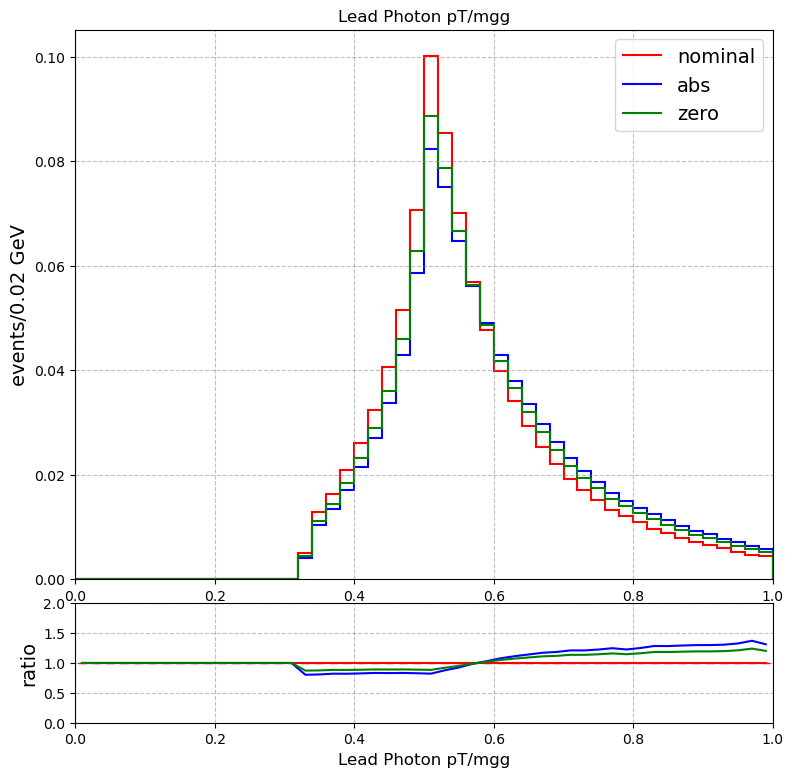

In [32]:
fig = plt.figure(figsize=(9, 9))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "LeadPhoton_pt_mgg"
min_ = 0.
max_ = 1
nbins = 50

h = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "axs", label="tot"))
h_zero_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "axs", label="tot"))
h_abs_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "axs", label="tot"))

h.fill(axs = MC_events[var][signal_cut], weight = MC_events.weight[signal_cut]/sum(MC_events.weight[signal_cut]))
h_zero_wgt.fill(axs = MC_events_zero[var][signal_cut], weight = MC_events_zero.weight[signal_cut]/sum(MC_events_zero.weight[signal_cut]))
h_abs_wgt.fill(axs = MC_events_abs[var][signal_cut], weight = abs(MC_events_abs.weight[signal_cut])/sum(MC_events_abs.weight[signal_cut]))

h.project("axs").plot(ax=ax0, color="red", label="nominal")
h_abs_wgt.project("axs").plot(ax=ax0, color="blue", label="abs")
h_zero_wgt.project("axs").plot(ax=ax0, color="green", label="zero")

mc = {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["nominal"], mc["edges"]["nominal"] = h.to_numpy()
mc["bins"]["zero"], mc["edges"]["zero"] = h_zero_wgt.to_numpy()
mc["bins"]["abs"], mc["edges"]["abs"] = h_abs_wgt.to_numpy()
half_bin = np.abs((mc["edges"]["nominal"][1] - mc["edges"]["nominal"][0])) / 2

for hist_ in ["nominal", "zero", "abs"]:
    mc["edges"][hist_] = mc["edges"][hist_] + half_bin
    mc["errs"][hist_] = np.sqrt(mc["bins"][hist_])

ax0.legend(prop={'size': 14})
ax0.set_ylabel(f'events/{2 * half_bin} GeV', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('Lead Photon pT/mgg', fontsize=12)
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)
# orizontal line at 1
ax1.plot(mc["edges"]["nominal"][:-1], ak.ones_like(mc["bins"]["nominal"]), color=colors[0], marker="_", linestyle="-", label="mc")

ratio = {}

for i, hist_ in enumerate(["abs", "zero"]):
    ratio[hist_] = ak.where(
        mc["bins"]["nominal"] != 0,
        mc["bins"][hist_] / mc["bins"]["nominal"],
        ak.ones_like(mc["bins"]["nominal"])
    )
    ax1.errorbar(mc["edges"]["nominal"][:-1], ratio[hist_], color=colors[i+1], marker="", linestyle="-", label=hist_)

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])
ax1.set_xlabel('Lead Photon pT/mgg', fontsize=12)
ax1.set_ylabel('ratio', fontsize=14)

plt.plot()
plt.show()

In [15]:
scale_lead = mc["bins"]["nominal"]/mc["bins"]["zero"]

/tmp/ipykernel_32925/1502044289.py:1: RuntimeWarning: invalid value encountered in true_divide
  scale_lead = mc["bins"]["nominal"]/mc["bins"]["zero"]


/tmp/ipykernel_32925/388607064.py:53: RuntimeWarning: invalid value encountered in true_divide
  mc["bins"][hist_] / mc["bins"]["nominal"],


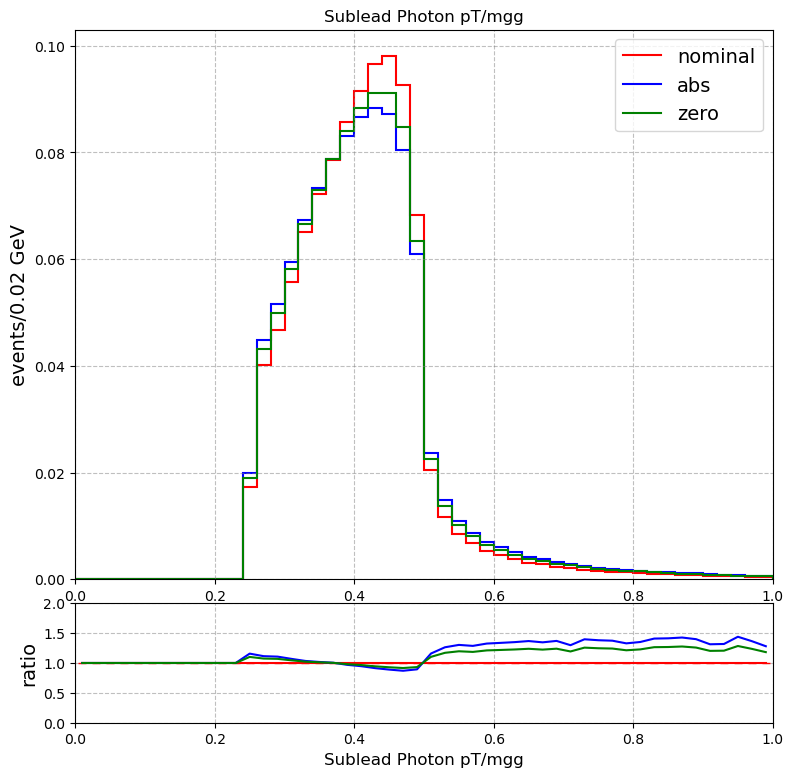

In [16]:
fig = plt.figure(figsize=(9, 9))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "SubleadPhoton_pt_mgg"
min_ = 0.
max_ = 1
nbins = 50

h = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "axs", label="tot"))
h_zero_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "axs", label="tot"))
h_abs_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "axs", label="tot"))

h.fill(axs = MC_events[var][signal_cut], weight = MC_events.weight[signal_cut]/sum(MC_events.weight[signal_cut]))
h_zero_wgt.fill(axs = MC_events_zero[var][signal_cut], weight = MC_events_zero.weight[signal_cut]/sum(MC_events_zero.weight[signal_cut]))
h_abs_wgt.fill(axs = MC_events_abs[var][signal_cut], weight = abs(MC_events_abs.weight[signal_cut])/sum(MC_events_abs.weight[signal_cut]))

h.project("axs").plot(ax=ax0, color="red", label="nominal")
h_abs_wgt.project("axs").plot(ax=ax0, color="blue", label="abs")
h_zero_wgt.project("axs").plot(ax=ax0, color="green", label="zero")

mc = {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["nominal"], mc["edges"]["nominal"] = h.to_numpy()
mc["bins"]["zero"], mc["edges"]["zero"] = h_zero_wgt.to_numpy()
mc["bins"]["abs"], mc["edges"]["abs"] = h_abs_wgt.to_numpy()
half_bin = np.abs((mc["edges"]["nominal"][1] - mc["edges"]["nominal"][0])) / 2

for hist_ in ["nominal", "zero", "abs"]:
    mc["edges"][hist_] = mc["edges"][hist_] + half_bin
    mc["errs"][hist_] = np.sqrt(mc["bins"][hist_])

ax0.legend(prop={'size': 14})
ax0.set_ylabel(f'events/{2 * half_bin} GeV', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('Sublead Photon pT/mgg', fontsize=12)
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)
# orizontal line at 1
ax1.plot(mc["edges"]["nominal"][:-1], ak.ones_like(mc["bins"]["nominal"]), color=colors[0], marker="_", linestyle="-", label="mc")

ratio = {}

for i, hist_ in enumerate(["abs", "zero"]):
    ratio[hist_] = ak.where(
        mc["bins"]["nominal"] != 0,
        mc["bins"][hist_] / mc["bins"]["nominal"],
        ak.ones_like(mc["bins"]["nominal"])
    )
    ax1.errorbar(mc["edges"]["nominal"][:-1], ratio[hist_], color=colors[i+1], marker="", linestyle="-", label=hist_)

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])
ax1.set_xlabel('Sublead Photon pT/mgg', fontsize=12)
ax1.set_ylabel('ratio', fontsize=14)

plt.plot()
plt.show()

In [17]:
scale_sublead = mc["bins"]["nominal"]/mc["bins"]["zero"]

/tmp/ipykernel_32925/1199970729.py:1: RuntimeWarning: invalid value encountered in true_divide
  scale_sublead = mc["bins"]["nominal"]/mc["bins"]["zero"]


# Lead and sublead pt scale factor

In [18]:


def multibinning(inputs_: list, edges_: list, content_, flow_: str):
    return cs.MultiBinning(
        nodetype="multibinning",
        inputs=inputs_,
        edges=edges_,
        content=content_,
        flow=flow_,
    )

def binning(inputs_: str, edges_: list, content_, flow_: str):
    return cs.Binning(
        nodetype="binning",
        input=inputs_,
        edges=edges_,
        content=content_,
        flow=flow_,
    )


In [23]:
inputs_ = "lead_pt_mgg"
edges_ = list(h.to_numpy()[1])

sf = []
var = []
for i, val in enumerate(scale_lead):
    if math.isnan(val):
        sf.append(1.)
    else:
        sf.append(val)
    var.append(1.)


content_ = {
    "nominal": sf,
    "up": var,
    "down": var,
}
print(sf)
flow_ = "clamp"

scale_lead = cs.Correction(
    name="scale_lead",
    version=1,
    inputs=[
        cs.Variable(name="systematic", type="string", description="Systematic variation"),
        cs.Variable(name="lead_pt_mgg", type="real", description="Lead Photon pt/mgg ratio"),
        ],
    output=cs.Variable(
        name="scale_lead",
        type="real",
        description="Multiplicative correction to event weight to account for the absence of negative weights in XGBoost",
    ),
    data=cs.Category(
        nodetype="category",
        input="systematic",
        content=[
            {
                "key": "nominal",
                "value": binning(inputs_, edges_, content_["nominal"], flow_),
            },
            {
                "key": "up",
                "value": binning(inputs_, edges_, content_["up"], flow_),
            },
            {
                "key": "down",
                "value": binning(inputs_, edges_, content_["down"], flow_),
            },
        ],
    ),
    )

rich.print(scale_lead)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.1464553586231527, 1.141848966543603, 1.131022229540627, 1.1318820856045955, 1.1269311110863318, 1.1211122743818804, 1.1230703426808426, 1.1210316229594308, 1.1253923706876803, 1.1305036566793931, 1.08582121764884, 1.0515708177458905, 1.0087995996305217, 0.9804100991803891, 0.9510994394999379, 0.9315977855378154, 0.9155365914253595, 0.9002200006512863, 0.8931727388108229, 0.8800625273508546, 0.8801575179525376, 0.8728278545166115, 0.8619351466983666, 0.8722588257961136, 0.860552584674124, 0.8444925635275875, 0.8451062483744595, 0.8409202934186509, 0.8376754499847547, 0.8374650262850561, 0.8344617457181596, 0.8253894672633115, 0.8060456018986285, 0.8314123996433799]


📈 scale_lead (v1)
No description
Node counts: Category: 1, Binning: 3
╭───────── ▶ input ─────────╮ ╭─────────────────── ▶ input ───────────────────╮
│ systematic (string)       │ │ lead_pt_mgg (real)                            │
│ Systematic variation      │ │ Lead Photon pt/mgg ratio                      │
│ Values: down, nominal, up │ │ Range: [0.0, 0.9999999999999999), overflow ok │
╰───────────────────────────╯ ╰───────────────────────────────────────────────╯
╭───────────────────────────────────────────── ◀ output ──────────────────────────────────────────────╮
│ scale_lead (real)                                                                                   │
│ Multiplicative correction to event weight to account for the absence of negative weights in XGBoost │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [24]:
cset = cs.CorrectionSet(
    schema_version=2,
    description="scale_lead",
    corrections=[
        scale_lead,
    ],
)

# if we're not just checking an existing json we create a new one

with open("scale_lead.json", "w") as fout:
    fout.write(cset.json(exclude_unset=True))

import gzip
with gzip.open("scale_lead.json.gz", "wt") as fout:
    fout.write(cset.json(exclude_unset=True))

print("Reading back...")

file = "scale_lead.json"
ceval = correctionlib.CorrectionSet.from_file(file)
for corr in ceval.values():
    print(f"Correction {corr.name} has {len(corr.inputs)} inputs")
    for ix in corr.inputs:
        print(f"   Input {ix.name} ({ix.type}): {ix.description}")

lead_sf = ceval["scale_lead"].evaluate("nominal", MC_events_zero.LeadPhoton_pt_mgg)

Reading back...
Correction scale_lead has 2 inputs
   Input systematic (string): Systematic variation
   Input lead_pt_mgg (real): Lead Photon pt/mgg ratio


In [25]:
inputs_ = "sublead_pt_mgg"

sf = []
var = []
for i, val in enumerate(scale_sublead):
    if math.isnan(val):
        sf.append(1)
    else:
        sf.append(val)
    var.append(1.)

content_ = {
    "nominal": sf,
    "up": var,
    "down": var,
}
flow_ = "clamp"

scale_sublead = cs.Correction(
    name="scale_sublead",
    version=1,
    inputs=[
        cs.Variable(name="systematic", type="string", description="Systematic variation"),
        cs.Variable(name="sublead_pt_mgg", type="real", description="Sublead Photon pt/mgg ratio"),
        ],
    output=cs.Variable(
        name="scale_sublead",
        type="real",
        description="Multiplicative correction to event weight to account for the absence of negative weights in XGBoost",
    ),
    data=cs.Category(
        nodetype="category",
        input="systematic",
        content=[
            {
                "key": "nominal",
                "value": binning(inputs_, edges_, content_["nominal"], flow_),
            },
            {
                "key": "up",
                "value": binning(inputs_, edges_, content_["up"], flow_),
            },
            {
                "key": "down",
                "value": binning(inputs_, edges_, content_["down"], flow_),
            },
        ],
    ),
    )

rich.print(scale_sublead)

📈 scale_sublead (v1)
No description
Node counts: Category: 1, Binning: 3
╭───────── ▶ input ─────────╮ ╭─────────────────── ▶ input ───────────────────╮
│ systematic (string)       │ │ sublead_pt_mgg (real)                         │
│ Systematic variation      │ │ Sublead Photon pt/mgg ratio                   │
│ Values: down, nominal, up │ │ Range: [0.0, 0.9999999999999999), overflow ok │
╰───────────────────────────╯ ╰───────────────────────────────────────────────╯
╭───────────────────────────────────────────── ◀ output ──────────────────────────────────────────────╮
│ scale_sublead (real)                                                                                │
│ Multiplicative correction to event weight to account for the absence of negative weights in XGBoost │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [26]:
cset = cs.CorrectionSet(
    schema_version=2,
    description="scale_sublead",
    corrections=[
        scale_sublead,
    ],
)

# if we're not just checking an existing json we create a new one

with open("scale_sublead.json", "w") as fout:
    fout.write(cset.json(exclude_unset=True))

import gzip
with gzip.open("scale_sublead.json.gz", "wt") as fout:
    fout.write(cset.json(exclude_unset=True))

print("Reading back...")

file = "scale_sublead.json"
ceval = correctionlib.CorrectionSet.from_file(file)
for corr in ceval.values():
    print(f"Correction {corr.name} has {len(corr.inputs)} inputs")
    for ix in corr.inputs:
        print(f"   Input {ix.name} ({ix.type}): {ix.description}")

sublead_sf = ceval["scale_sublead"].evaluate("nominal", MC_events_zero.SubleadPhoton_pt_mgg)

Reading back...
Correction scale_sublead has 2 inputs
   Input systematic (string): Systematic variation
   Input sublead_pt_mgg (real): Sublead Photon pt/mgg ratio


## multibin

In [ ]:
inputs_ = ["lead_pt_mgg", "sublead_pt_mgg"]
edges2d_ = [edges_, edges_]
content_ = {
    "nominal": [1.0, 1.0, 1.0, 1.0],
    "up": [1.0007, 1.0022, 1.00005, 1.00251],
    "down": [0.9993, 0.9978, 0.99995, 0.99749],
}
flow_ = "clamp"

SF = cs.Correction(
    name="FNUF",
    version=1,
    inputs=[
        cs.Variable(
            name="systematic", type="string", description="Systematic variation"
        ),
        cs.Variable(name="eta", type="real", description="Photon eta"),
        cs.Variable(
            name="r9",
            type="real",
            description="Photon full 5x5 R9, ratio E3x3/ERAW, where E3x3 is the energy sum of the 3 by 3 crystals surrounding the supercluster seed crystal and ERAW is the raw energy sum of the supercluster",
        ),
    ],
    output=cs.Variable(
        name="Ecorr",
        type="real",
        description="Multiplicative correction to photon energy",
    ),
    data=cs.Category(
        nodetype="category",
        input="systematic",
        content=[
            {
                "key": "nominal",
                "value": multibinning(inputs_, edges_, content_["nominal"], flow_),
            },
            {
                "key": "up",
                "value": multibinning(inputs_, edges_, content_["up"], flow_),
            },
            {
                "key": "down",
                "value": multibinning(inputs_, edges_, content_["down"], flow_),
            },
        ],
    ),
)

rich.print(SF)

# corrected plots

/tmp/ipykernel_32925/3836890641.py:53: RuntimeWarning: invalid value encountered in true_divide
  mc["bins"][hist_] / mc["bins"]["nominal"],


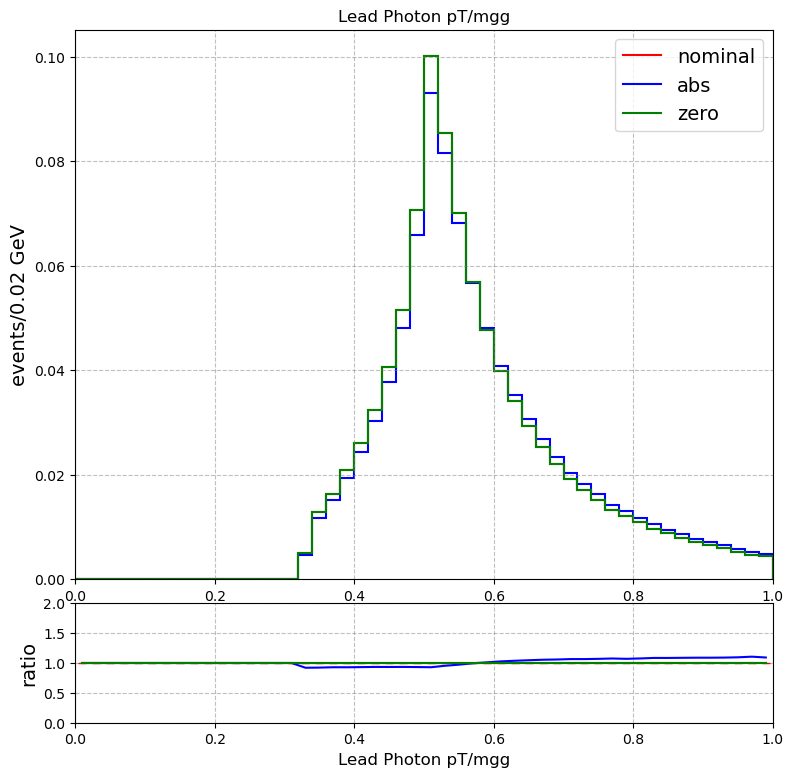

In [28]:
fig = plt.figure(figsize=(9, 9))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "LeadPhoton_pt_mgg"
min_ = 0.
max_ = 1
nbins = 50

h = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "axs", label="tot"))
h_zero_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "axs", label="tot"))
h_abs_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "axs", label="tot"))

h.fill(axs = MC_events[var][signal_cut], weight = MC_events.weight[signal_cut]/sum(MC_events.weight[signal_cut]))
h_zero_wgt.fill(axs = MC_events_zero[var][signal_cut], weight = MC_events_zero.weight[signal_cut]/sum(MC_events_zero.weight[signal_cut])*lead_sf[signal_cut])
h_abs_wgt.fill(axs = MC_events_abs[var][signal_cut], weight = abs(MC_events_abs.weight[signal_cut])/sum(MC_events_abs.weight[signal_cut])*lead_sf[signal_cut])

h.project("axs").plot(ax=ax0, color="red", label="nominal")
h_abs_wgt.project("axs").plot(ax=ax0, color="blue", label="abs")
h_zero_wgt.project("axs").plot(ax=ax0, color="green", label="zero")

mc = {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["nominal"], mc["edges"]["nominal"] = h.to_numpy()
mc["bins"]["zero"], mc["edges"]["zero"] = h_zero_wgt.to_numpy()
mc["bins"]["abs"], mc["edges"]["abs"] = h_abs_wgt.to_numpy()
half_bin = np.abs((mc["edges"]["nominal"][1] - mc["edges"]["nominal"][0])) / 2

for hist_ in ["nominal", "zero", "abs"]:
    mc["edges"][hist_] = mc["edges"][hist_] + half_bin
    mc["errs"][hist_] = np.sqrt(mc["bins"][hist_])

ax0.legend(prop={'size': 14})
ax0.set_ylabel(f'events/{2 * half_bin} GeV', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('Corrected lead Photon pT/mgg', fontsize=12)
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)
# orizontal line at 1
ax1.plot(mc["edges"]["nominal"][:-1], ak.ones_like(mc["bins"]["nominal"]), color=colors[0], marker="_", linestyle="-", label="mc")

ratio = {}

for i, hist_ in enumerate(["abs", "zero"]):
    ratio[hist_] = ak.where(
        mc["bins"]["nominal"] != 0,
        mc["bins"][hist_] / mc["bins"]["nominal"],
        ak.ones_like(mc["bins"]["nominal"])
    )
    ax1.errorbar(mc["edges"]["nominal"][:-1], ratio[hist_], color=colors[i+1], marker="", linestyle="-", label=hist_)

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])
ax1.set_xlabel('Lead Photon pT/mgg', fontsize=12)
ax1.set_ylabel('ratio', fontsize=14)

plt.plot()
plt.show()

/tmp/ipykernel_32925/2808416637.py:53: RuntimeWarning: invalid value encountered in true_divide
  mc["bins"][hist_] / mc["bins"]["nominal"],


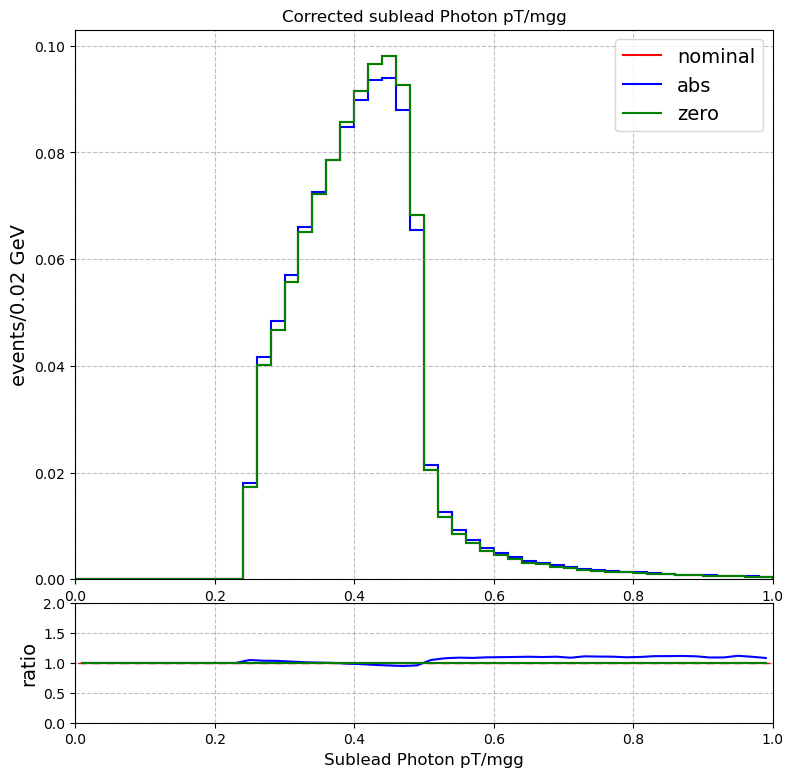

In [29]:
fig = plt.figure(figsize=(9, 9))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "SubleadPhoton_pt_mgg"
min_ = 0.
max_ = 1
nbins = 50

h = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "axs", label="tot"))
h_zero_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "axs", label="tot"))
h_abs_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "axs", label="tot"))

h.fill(axs = MC_events[var][signal_cut], weight = MC_events.weight[signal_cut]/sum(MC_events.weight[signal_cut]))
h_zero_wgt.fill(axs = MC_events_zero[var][signal_cut], weight = MC_events_zero.weight[signal_cut]/sum(MC_events_zero.weight[signal_cut])*sublead_sf[signal_cut])
h_abs_wgt.fill(axs = MC_events_abs[var][signal_cut], weight = abs(MC_events_abs.weight[signal_cut])/sum(MC_events_abs.weight[signal_cut])*sublead_sf[signal_cut])

h.project("axs").plot(ax=ax0, color="red", label="nominal")
h_abs_wgt.project("axs").plot(ax=ax0, color="blue", label="abs")
h_zero_wgt.project("axs").plot(ax=ax0, color="green", label="zero")

mc = {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["nominal"], mc["edges"]["nominal"] = h.to_numpy()
mc["bins"]["zero"], mc["edges"]["zero"] = h_zero_wgt.to_numpy()
mc["bins"]["abs"], mc["edges"]["abs"] = h_abs_wgt.to_numpy()
half_bin = np.abs((mc["edges"]["nominal"][1] - mc["edges"]["nominal"][0])) / 2

for hist_ in ["nominal", "zero", "abs"]:
    mc["edges"][hist_] = mc["edges"][hist_] + half_bin
    mc["errs"][hist_] = np.sqrt(mc["bins"][hist_])

ax0.legend(prop={'size': 14})
ax0.set_ylabel(f'events/{2 * half_bin} GeV', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('Corrected sublead Photon pT/mgg', fontsize=12)
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)
# orizontal line at 1
ax1.plot(mc["edges"]["nominal"][:-1], ak.ones_like(mc["bins"]["nominal"]), color=colors[0], marker="_", linestyle="-", label="mc")

ratio = {}

for i, hist_ in enumerate(["abs", "zero"]):
    ratio[hist_] = ak.where(
        mc["bins"]["nominal"] != 0,
        mc["bins"][hist_] / mc["bins"]["nominal"],
        ak.ones_like(mc["bins"]["nominal"])
    )
    ax1.errorbar(mc["edges"]["nominal"][:-1], ratio[hist_], color=colors[i+1], marker="", linestyle="-", label=hist_)

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])
ax1.set_xlabel('Sublead Photon pT/mgg', fontsize=12)
ax1.set_ylabel('ratio', fontsize=14)

plt.plot()
plt.show()

# double corrected plots

/tmp/ipykernel_534/3845786171.py:53: RuntimeWarning: invalid value encountered in true_divide
  mc["bins"][hist_] / mc["bins"]["nominal"],


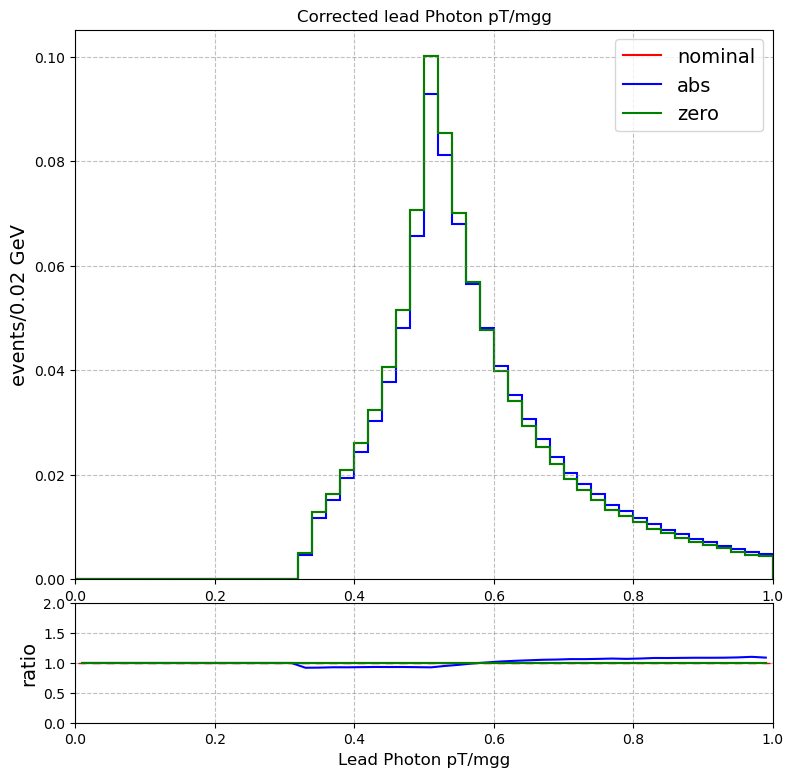

In [55]:
fig = plt.figure(figsize=(9, 9))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "LeadPhoton_pt_mgg"
min_ = 0.
max_ = 1
nbins = 50

h = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "axs", label="tot"))
h_zero_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "axs", label="tot"))
h_abs_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "axs", label="tot"))

h.fill(axs = MC_events[var][signal_cut], weight = MC_events.weight[signal_cut]/sum(MC_events.weight[signal_cut]))
h_zero_wgt.fill(axs = MC_events_zero[var][signal_cut], weight = MC_events_zero.weight[signal_cut]/sum(MC_events_zero.weight[signal_cut])*zero_to_nominal.to_evaluator().evaluate(MC_events_zero[var][signal_cut], MC_events_zero[var2][signal_cut]))
h_abs_wgt.fill(axs = MC_events_abs[var][signal_cut], weight = abs(MC_events_abs.weight[signal_cut])/sum(MC_events_abs.weight[signal_cut])*zero_to_nominal.to_evaluator().evaluate(MC_events_abs[var][signal_cut], MC_events_abs[var2][signal_cut]))

h.project("axs").plot(ax=ax0, color="red", label="nominal")
h_abs_wgt.project("axs").plot(ax=ax0, color="blue", label="abs")
h_zero_wgt.project("axs").plot(ax=ax0, color="green", label="zero")

mc = {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["nominal"], mc["edges"]["nominal"] = h.to_numpy()
mc["bins"]["zero"], mc["edges"]["zero"] = h_zero_wgt.to_numpy()
mc["bins"]["abs"], mc["edges"]["abs"] = h_abs_wgt.to_numpy()
half_bin = np.abs((mc["edges"]["nominal"][1] - mc["edges"]["nominal"][0])) / 2

for hist_ in ["nominal", "zero", "abs"]:
    mc["edges"][hist_] = mc["edges"][hist_] + half_bin
    mc["errs"][hist_] = np.sqrt(mc["bins"][hist_])

ax0.legend(prop={'size': 14})
ax0.set_ylabel(f'events/{2 * half_bin} GeV', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('Corrected lead Photon pT/mgg', fontsize=12)
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)
# orizontal line at 1
ax1.plot(mc["edges"]["nominal"][:-1], ak.ones_like(mc["bins"]["nominal"]), color=colors[0], marker="_", linestyle="-", label="mc")

ratio = {}

for i, hist_ in enumerate(["abs", "zero"]):
    ratio[hist_] = ak.where(
        mc["bins"]["nominal"] != 0,
        mc["bins"][hist_] / mc["bins"]["nominal"],
        ak.ones_like(mc["bins"]["nominal"])
    )
    ax1.errorbar(mc["edges"]["nominal"][:-1], ratio[hist_], color=colors[i+1], marker="", linestyle="-", label=hist_)

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])
ax1.set_xlabel('Lead Photon pT/mgg', fontsize=12)
ax1.set_ylabel('ratio', fontsize=14)

plt.plot()
plt.show()

/tmp/ipykernel_534/4011090070.py:53: RuntimeWarning: invalid value encountered in true_divide
  mc["bins"][hist_] / mc["bins"]["nominal"],


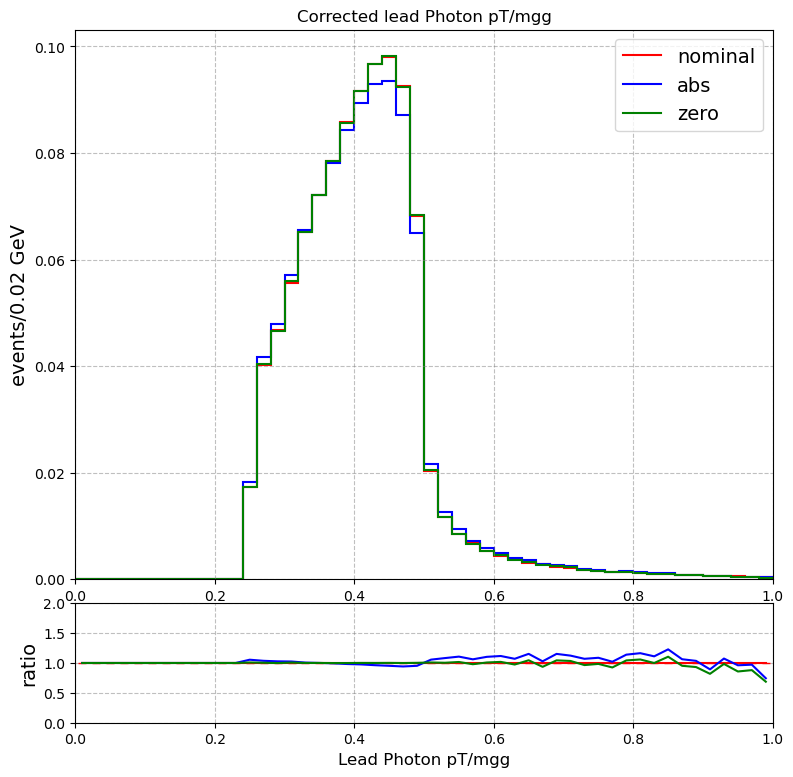

In [56]:
fig = plt.figure(figsize=(9, 9))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "SubleadPhoton_pt_mgg"
min_ = 0.
max_ = 1
nbins = 50

h = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "axs", label="tot"))
h_zero_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "axs", label="tot"))
h_abs_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "axs", label="tot"))

h.fill(axs = MC_events[var][signal_cut], weight = MC_events.weight[signal_cut]/sum(MC_events.weight[signal_cut]))
h_zero_wgt.fill(axs = MC_events_zero[var][signal_cut], weight = MC_events_zero.weight[signal_cut]/sum(MC_events_zero.weight[signal_cut])*zero_to_nominal.to_evaluator().evaluate(MC_events_zero["LeadPhoton_pt_mgg"][signal_cut], MC_events_zero["SubleadPhoton_pt_mgg"][signal_cut]))
h_abs_wgt.fill(axs = MC_events_abs[var][signal_cut], weight = abs(MC_events_abs.weight[signal_cut])/sum(MC_events_abs.weight[signal_cut])*zero_to_nominal.to_evaluator().evaluate(MC_events_abs["LeadPhoton_pt_mgg"][signal_cut], MC_events_abs["SubleadPhoton_pt_mgg"][signal_cut]))

h.project("axs").plot(ax=ax0, color="red", label="nominal")
h_abs_wgt.project("axs").plot(ax=ax0, color="blue", label="abs")
h_zero_wgt.project("axs").plot(ax=ax0, color="green", label="zero")

mc = {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["nominal"], mc["edges"]["nominal"] = h.to_numpy()
mc["bins"]["zero"], mc["edges"]["zero"] = h_zero_wgt.to_numpy()
mc["bins"]["abs"], mc["edges"]["abs"] = h_abs_wgt.to_numpy()
half_bin = np.abs((mc["edges"]["nominal"][1] - mc["edges"]["nominal"][0])) / 2

for hist_ in ["nominal", "zero", "abs"]:
    mc["edges"][hist_] = mc["edges"][hist_] + half_bin
    mc["errs"][hist_] = np.sqrt(mc["bins"][hist_])

ax0.legend(prop={'size': 14})
ax0.set_ylabel(f'events/{2 * half_bin} GeV', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('Corrected lead Photon pT/mgg', fontsize=12)
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)
# orizontal line at 1
ax1.plot(mc["edges"]["nominal"][:-1], ak.ones_like(mc["bins"]["nominal"]), color=colors[0], marker="_", linestyle="-", label="mc")

ratio = {}

for i, hist_ in enumerate(["abs", "zero"]):
    ratio[hist_] = ak.where(
        mc["bins"]["nominal"] != 0,
        mc["bins"][hist_] / mc["bins"]["nominal"],
        ak.ones_like(mc["bins"]["nominal"])
    )
    ax1.errorbar(mc["edges"]["nominal"][:-1], ratio[hist_], color=colors[i+1], marker="", linestyle="-", label=hist_)

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])
ax1.set_xlabel('Lead Photon pT/mgg', fontsize=12)
ax1.set_ylabel('ratio', fontsize=14)

plt.plot()
plt.show()

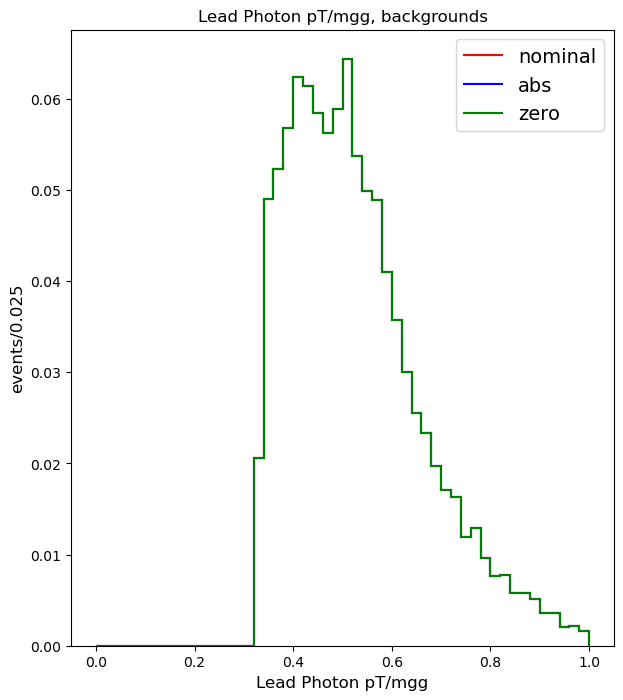

In [37]:
fig, axs = plt.subplots(1,1, figsize=(7, 8))

h_lead_pt_mgg_bkg = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "lead_pt_mgg", label="tot"))
h_lead_pt_mgg_bkg_zero_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "lead_pt_mgg", label="tot"))
h_lead_pt_mgg_bkg_abs_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "lead_pt_mgg", label="tot"))

h_lead_pt_mgg_bkg.fill(lead_pt_mgg = MC_events.LeadPhoton_pt_mgg[(MC_events.proc_id < 0)], weight = MC_events.weight[(MC_events.proc_id < 0)]/sum(MC_events.weight[(MC_events.proc_id < 0)]))
h_lead_pt_mgg_bkg_zero_wgt.fill(lead_pt_mgg = MC_events_zero.LeadPhoton_pt_mgg[(MC_events_zero.proc_id < 0)], weight = MC_events_zero.weight[(MC_events_zero.proc_id < 0)]/sum(MC_events_zero.weight[(MC_events_zero.proc_id < 0)]))
h_lead_pt_mgg_bkg_abs_wgt.fill(lead_pt_mgg = MC_events_abs.LeadPhoton_pt_mgg[(MC_events_abs.proc_id < 0)], weight = abs(MC_events_abs.weight[(MC_events_abs.proc_id < 0)])/sum(MC_events_abs.weight[(MC_events_abs.proc_id < 0)]))

h_lead_pt_mgg_bkg.project("lead_pt_mgg").plot(ax=axs, color="red", label="nominal")
h_lead_pt_mgg_bkg_abs_wgt.project("lead_pt_mgg").plot(ax=axs, color="blue", label="abs")
h_lead_pt_mgg_bkg_zero_wgt.project("lead_pt_mgg").plot(ax=axs, color="green", label="zero")

axs.legend(prop={'size': 14})
axs.set_ylabel('events/0.025', fontsize=12)
axs.set_xlabel('Lead Photon pT/mgg', fontsize=12)
axs.set_title('Lead Photon pT/mgg, backgrounds', fontsize=12)

plt.plot()
plt.show()

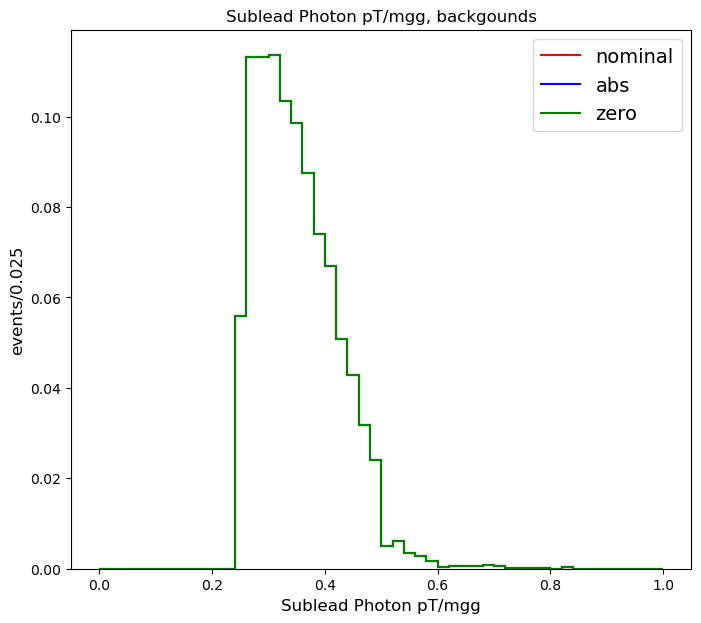

In [39]:
fig, axs = plt.subplots(1,1, figsize=(8, 7))

min_ = 0.
max_ = 1
nbins = 50

h_sublead_pt_mgg_bkg = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "axs", label="tot"))
h_sublead_pt_mgg_bkg_zero_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "axs", label="tot"))
h_sublead_pt_mgg_bkg_abs_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "axs", label="tot"))

h_sublead_pt_mgg_bkg.fill(axs = MC_events.SubleadPhoton_pt_mgg[(MC_events.proc_id < 0)], weight = MC_events.weight[(MC_events.proc_id < 0)]/sum(MC_events.weight[(MC_events.proc_id < 0)]))
h_sublead_pt_mgg_bkg_zero_wgt.fill(axs = MC_events_zero.SubleadPhoton_pt_mgg[(MC_events_zero.proc_id < 0)], weight = MC_events_zero.weight[(MC_events_zero.proc_id < 0)]/sum(MC_events_zero.weight[(MC_events_zero.proc_id < 0)]))
h_sublead_pt_mgg_bkg_abs_wgt.fill(axs = MC_events_abs.SubleadPhoton_pt_mgg[(MC_events_abs.proc_id < 0)], weight = abs(MC_events_abs.weight[(MC_events_abs.proc_id < 0)])/sum(MC_events_abs.weight[(MC_events_abs.proc_id < 0)]))

h_sublead_pt_mgg_bkg.project("axs").plot(ax=axs, color="red", label="nominal")
h_sublead_pt_mgg_bkg_abs_wgt.project("axs").plot(ax=axs, color="blue", label="abs")
h_sublead_pt_mgg_bkg_zero_wgt.project("axs").plot(ax=axs, color="green", label="zero")

axs.legend(prop={'size': 14})
axs.set_ylabel('events/0.025', fontsize=12)
axs.set_xlabel('Sublead Photon pT/mgg', fontsize=12)
axs.set_title('Sublead Photon pT/mgg, backgounds', fontsize=12)

plt.plot()
plt.show()

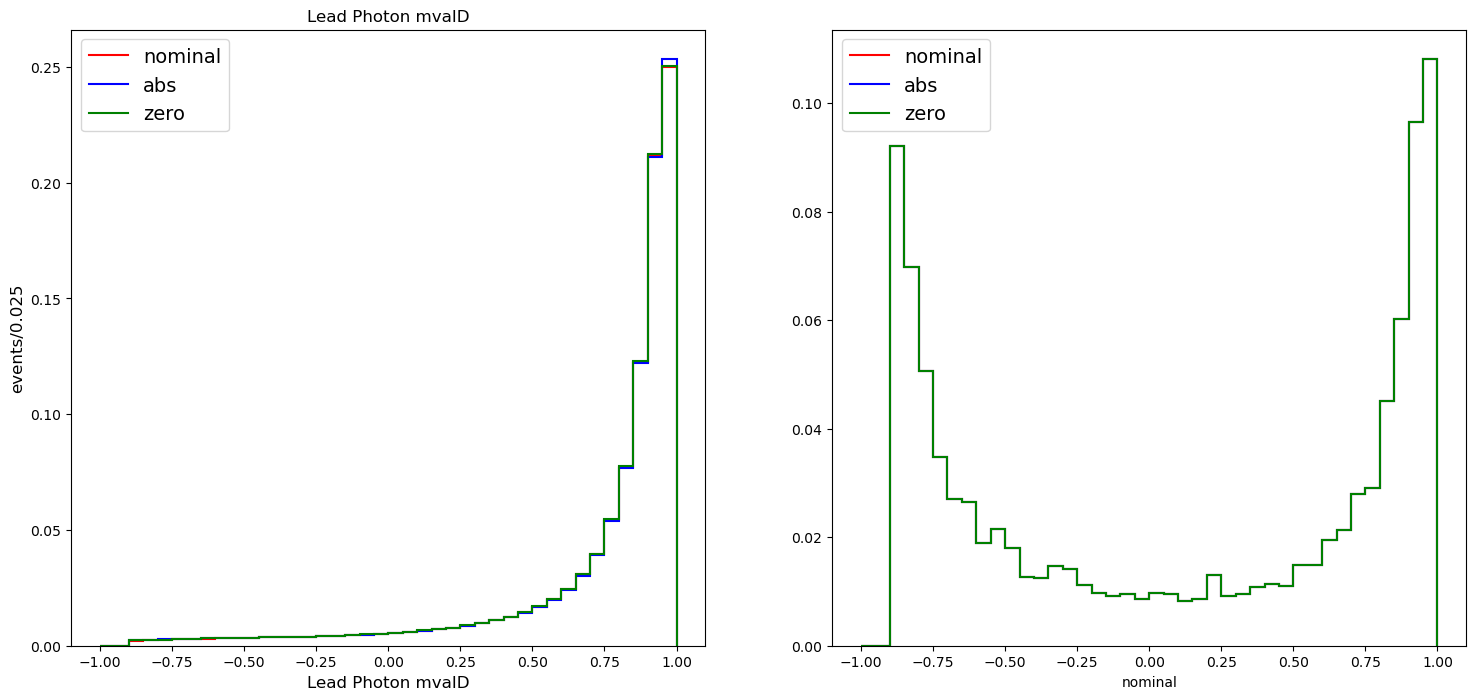

In [26]:
fig, axs = plt.subplots(1,2, figsize=(18, 8))

min_ = -1.
max_ = 1
nbins = 40

h_lead_pt_mgg_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "mva", label="nominal"))
h_lead_pt_mgg_sig_zero_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "mva", label="zero"))
h_lead_pt_mgg_sig_abs_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "mva", label="abs"))

h_lead_pt_mgg_bkg = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "mva", label="nominal"))
h_lead_pt_mgg_bkg_zero_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "mva", label="zero"))
h_lead_pt_mgg_bkg_abs_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "mva", label="abs"))

h_lead_pt_mgg_sig.fill(mva = MC_events.LeadPhoton_mvaID[(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)]/sum(MC_events.weight[(MC_events.proc_id > 0)]))
h_lead_pt_mgg_sig_zero_wgt.fill(mva = MC_events_zero.LeadPhoton_mvaID[(MC_events_zero.proc_id > 0)], weight = MC_events_zero.weight[(MC_events_zero.proc_id > 0)]/sum(MC_events_zero.weight[(MC_events_zero.proc_id > 0)]) * correction[(MC_events_zero.proc_id > 0)] * sublead_sf[(MC_events_zero.proc_id > 0)])
h_lead_pt_mgg_sig_abs_wgt.fill(mva = MC_events_abs.LeadPhoton_mvaID[(MC_events_abs.proc_id > 0)], weight = abs(MC_events_abs.weight[(MC_events_abs.proc_id > 0)])/sum(MC_events_abs.weight[(MC_events_abs.proc_id > 0)]))

h_lead_pt_mgg_bkg.fill(mva = MC_events.LeadPhoton_mvaID[(MC_events.proc_id < 0)], weight = MC_events.weight[(MC_events.proc_id < 0)]/sum(MC_events.weight[(MC_events.proc_id < 0)]))
h_lead_pt_mgg_bkg_zero_wgt.fill(mva = MC_events_zero.LeadPhoton_mvaID[(MC_events_zero.proc_id < 0)], weight = MC_events_zero.weight[(MC_events_zero.proc_id < 0)]/sum(MC_events_zero.weight[(MC_events_zero.proc_id < 0)]))
h_lead_pt_mgg_bkg_abs_wgt.fill(mva = MC_events_abs.LeadPhoton_mvaID[(MC_events_abs.proc_id < 0)], weight = abs(MC_events_abs.weight[(MC_events_abs.proc_id < 0)])/sum(MC_events_abs.weight[(MC_events_abs.proc_id < 0)]))

h_lead_pt_mgg_sig.project("mva").plot(ax=axs[0], color="red", label="nominal")
h_lead_pt_mgg_sig_abs_wgt.project("mva").plot(ax=axs[0], color="blue", label="abs")
h_lead_pt_mgg_sig_zero_wgt.project("mva").plot(ax=axs[0], color="green", label="zero")

h_lead_pt_mgg_bkg.project("mva").plot(ax=axs[1], color="red", label="nominal")
h_lead_pt_mgg_bkg_abs_wgt.project("mva").plot(ax=axs[1], color="blue", label="abs")
h_lead_pt_mgg_bkg_zero_wgt.project("mva").plot(ax=axs[1], color="green", label="zero")

axs[0].legend(prop={'size': 14})
axs[0].set_ylabel('events/0.025', fontsize=12)
axs[0].set_xlabel('Lead Photon mvaID', fontsize=12)
axs[0].set_title('Lead Photon mvaID', fontsize=12)
axs[1].legend(prop={'size': 14})

plt.plot()
plt.show()

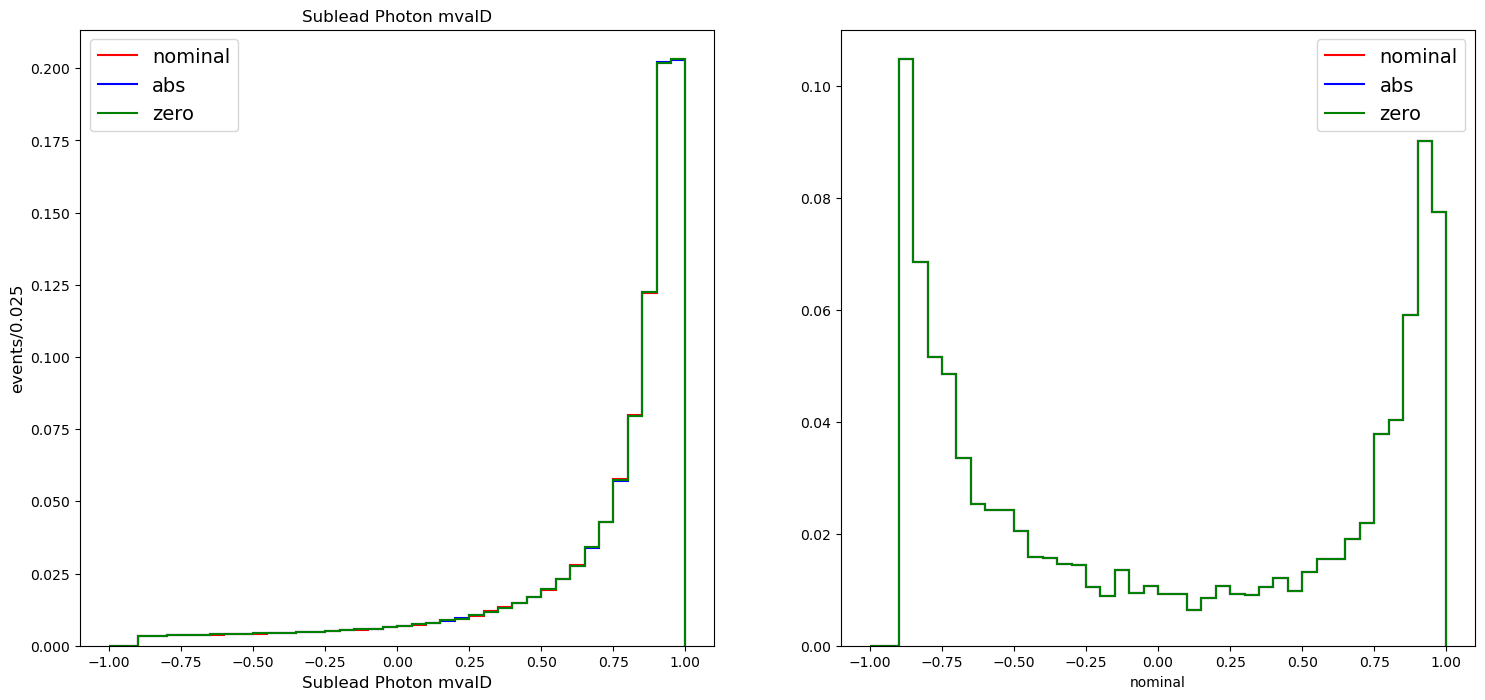

In [27]:
fig, axs = plt.subplots(1,2, figsize=(18, 8))

min_ = -1.
max_ = 1
nbins = 40

h_lead_pt_mgg_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "mva", label="nominal"))
h_lead_pt_mgg_sig_zero_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "mva", label="zero"))
h_lead_pt_mgg_sig_abs_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "mva", label="abs"))

h_lead_pt_mgg_bkg = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "mva", label="nominal"))
h_lead_pt_mgg_bkg_zero_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "mva", label="zero"))
h_lead_pt_mgg_bkg_abs_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "mva", label="abs"))

h_lead_pt_mgg_sig.fill(mva = MC_events.SubleadPhoton_mvaID[(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)]/sum(MC_events.weight[(MC_events.proc_id > 0)]))
h_lead_pt_mgg_sig_zero_wgt.fill(mva = MC_events_zero.SubleadPhoton_mvaID[(MC_events_zero.proc_id > 0)], weight = MC_events_zero.weight[(MC_events_zero.proc_id > 0)]/sum(MC_events_zero.weight[(MC_events_zero.proc_id > 0)]))
h_lead_pt_mgg_sig_abs_wgt.fill(mva = MC_events_abs.SubleadPhoton_mvaID[(MC_events_abs.proc_id > 0)], weight = abs(MC_events_abs.weight[(MC_events_abs.proc_id > 0)])/sum(MC_events_abs.weight[(MC_events_abs.proc_id > 0)]))

h_lead_pt_mgg_bkg.fill(mva = MC_events.SubleadPhoton_mvaID[(MC_events.proc_id < 0)], weight = MC_events.weight[(MC_events.proc_id < 0)]/sum(MC_events.weight[(MC_events.proc_id < 0)]))
h_lead_pt_mgg_bkg_zero_wgt.fill(mva = MC_events_zero.SubleadPhoton_mvaID[(MC_events_zero.proc_id < 0)], weight = MC_events_zero.weight[(MC_events_zero.proc_id < 0)]/sum(MC_events_zero.weight[(MC_events_zero.proc_id < 0)]))
h_lead_pt_mgg_bkg_abs_wgt.fill(mva = MC_events_abs.SubleadPhoton_mvaID[(MC_events_abs.proc_id < 0)], weight = abs(MC_events_abs.weight[(MC_events_abs.proc_id < 0)])/sum(MC_events_abs.weight[(MC_events_abs.proc_id < 0)]))

h_lead_pt_mgg_sig.project("mva").plot(ax=axs[0], color="red", label="nominal")
h_lead_pt_mgg_sig_abs_wgt.project("mva").plot(ax=axs[0], color="blue", label="abs")
h_lead_pt_mgg_sig_zero_wgt.project("mva").plot(ax=axs[0], color="green", label="zero")

h_lead_pt_mgg_bkg.project("mva").plot(ax=axs[1], color="red", label="nominal")
h_lead_pt_mgg_bkg_abs_wgt.project("mva").plot(ax=axs[1], color="blue", label="abs")
h_lead_pt_mgg_bkg_zero_wgt.project("mva").plot(ax=axs[1], color="green", label="zero")

axs[0].legend(prop={'size': 14})
axs[0].set_ylabel('events/0.025', fontsize=12)
axs[0].set_xlabel('Sublead Photon mvaID', fontsize=12)
axs[0].set_title('Sublead Photon mvaID', fontsize=12)
axs[1].legend(prop={'size': 14})

plt.plot()
plt.show()

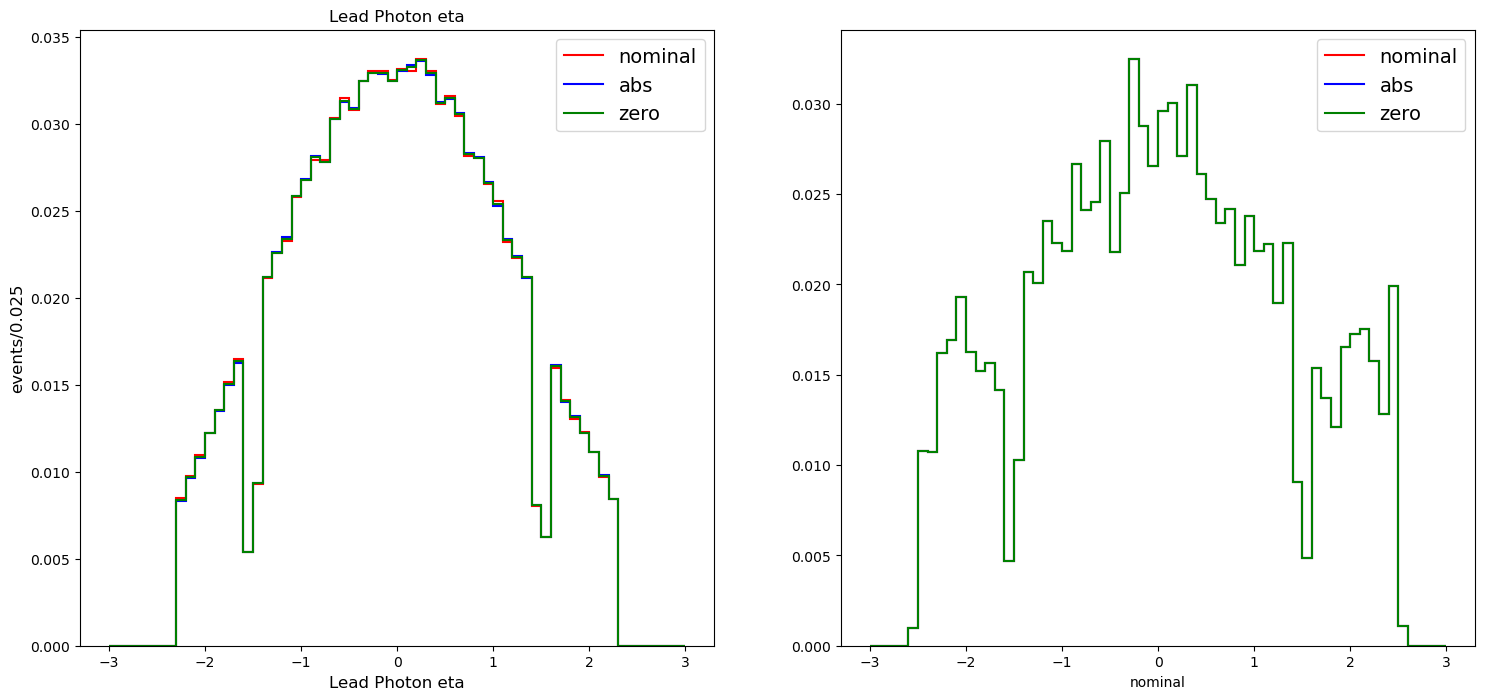

In [28]:
fig, axs = plt.subplots(1,2, figsize=(18, 8))

var = "LeadPhoton_eta"
min_ = -3.
max_ = 3
nbins = 60

h_lead_pt_mgg_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="nominal"))
h_lead_pt_mgg_sig_zero_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="zero"))
h_lead_pt_mgg_sig_abs_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="abs"))

h_lead_pt_mgg_bkg = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="nominal"))
h_lead_pt_mgg_bkg_zero_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="zero"))
h_lead_pt_mgg_bkg_abs_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="abs"))

h_lead_pt_mgg_sig.fill(ax = MC_events[var][(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)]/sum(MC_events.weight[(MC_events.proc_id > 0)]))
h_lead_pt_mgg_sig_zero_wgt.fill(ax = MC_events_zero[var][(MC_events_zero.proc_id > 0)], weight = MC_events_zero.weight[(MC_events_zero.proc_id > 0)]/sum(MC_events_zero.weight[(MC_events_zero.proc_id > 0)]))
h_lead_pt_mgg_sig_abs_wgt.fill(ax = MC_events_abs[var][(MC_events_abs.proc_id > 0)], weight = abs(MC_events_abs.weight[(MC_events_abs.proc_id > 0)])/sum(MC_events_abs.weight[(MC_events_abs.proc_id > 0)]))

h_lead_pt_mgg_bkg.fill(ax = MC_events[var][(MC_events.proc_id < 0)], weight = MC_events.weight[(MC_events.proc_id < 0)]/sum(MC_events.weight[(MC_events.proc_id < 0)]))
h_lead_pt_mgg_bkg_zero_wgt.fill(ax = MC_events_zero[var][(MC_events_zero.proc_id < 0)], weight = MC_events_zero.weight[(MC_events_zero.proc_id < 0)]/sum(MC_events_zero.weight[(MC_events_zero.proc_id < 0)]))
h_lead_pt_mgg_bkg_abs_wgt.fill(ax = MC_events_abs[var][(MC_events_abs.proc_id < 0)], weight = abs(MC_events_abs.weight[(MC_events_abs.proc_id < 0)])/sum(MC_events_abs.weight[(MC_events_abs.proc_id < 0)]))

h_lead_pt_mgg_sig.project("ax").plot(ax=axs[0], color="red", label="nominal")
h_lead_pt_mgg_sig_abs_wgt.project("ax").plot(ax=axs[0], color="blue", label="abs")
h_lead_pt_mgg_sig_zero_wgt.project("ax").plot(ax=axs[0], color="green", label="zero")

h_lead_pt_mgg_bkg.project("ax").plot(ax=axs[1], color="red", label="nominal")
h_lead_pt_mgg_bkg_abs_wgt.project("ax").plot(ax=axs[1], color="blue", label="abs")
h_lead_pt_mgg_bkg_zero_wgt.project("ax").plot(ax=axs[1], color="green", label="zero")

axs[0].legend(prop={'size': 14})
axs[0].set_ylabel('events/0.025', fontsize=12)
axs[0].set_xlabel('Lead Photon eta', fontsize=12)
axs[0].set_title('Lead Photon eta', fontsize=12)
axs[1].legend(prop={'size': 14})

plt.plot()
plt.show()

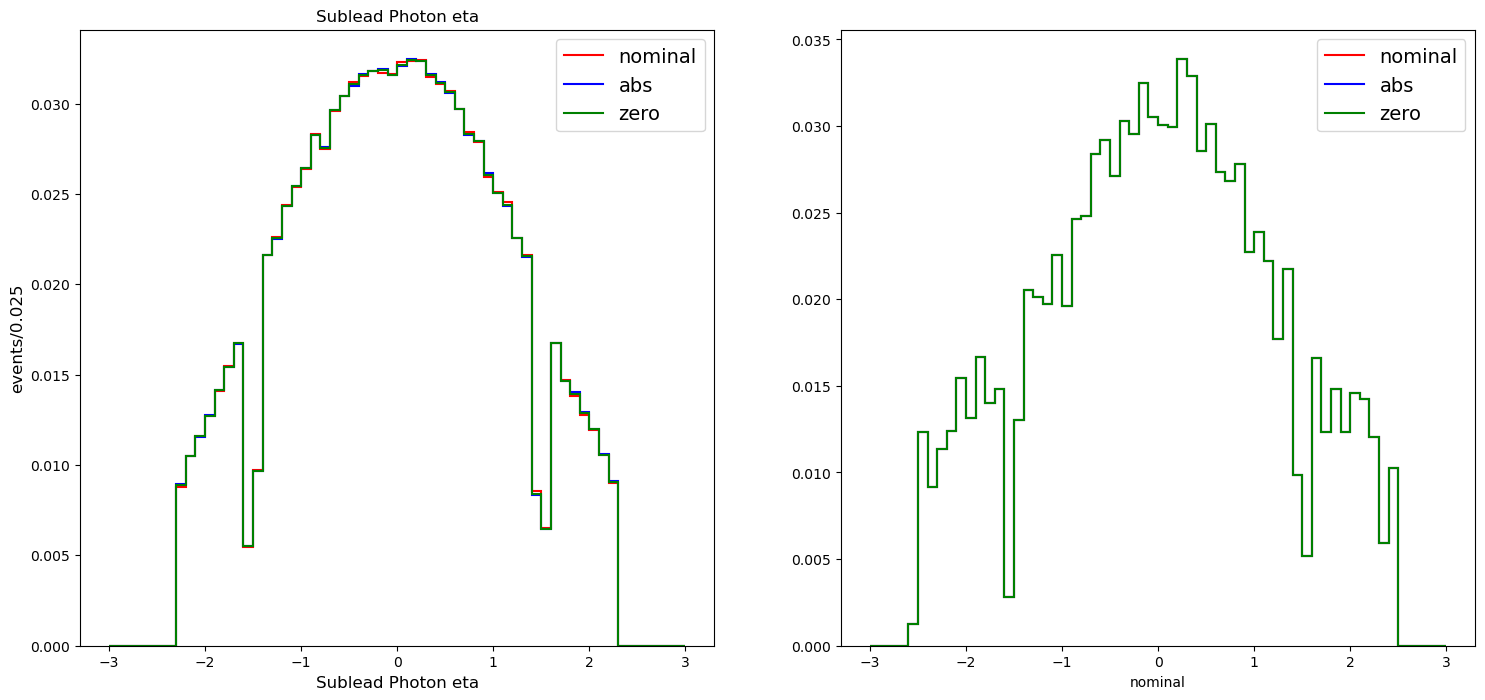

In [29]:
fig, axs = plt.subplots(1,2, figsize=(18, 8))

var = "SubleadPhoton_eta"
min_ = -3.
max_ = 3
nbins = 60

h_lead_pt_mgg_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="nominal"))
h_lead_pt_mgg_sig_zero_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="zero"))
h_lead_pt_mgg_sig_abs_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="abs"))

h_lead_pt_mgg_bkg = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="nominal"))
h_lead_pt_mgg_bkg_zero_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="zero"))
h_lead_pt_mgg_bkg_abs_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="abs"))

h_lead_pt_mgg_sig.fill(ax = MC_events[var][(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)]/sum(MC_events.weight[(MC_events.proc_id > 0)]))
h_lead_pt_mgg_sig_zero_wgt.fill(ax = MC_events_zero[var][(MC_events_zero.proc_id > 0)], weight = MC_events_zero.weight[(MC_events_zero.proc_id > 0)]/sum(MC_events_zero.weight[(MC_events_zero.proc_id > 0)]))
h_lead_pt_mgg_sig_abs_wgt.fill(ax = MC_events_abs[var][(MC_events_abs.proc_id > 0)], weight = abs(MC_events_abs.weight[(MC_events_abs.proc_id > 0)])/sum(MC_events_abs.weight[(MC_events_abs.proc_id > 0)]))

h_lead_pt_mgg_bkg.fill(ax = MC_events[var][(MC_events.proc_id < 0)], weight = MC_events.weight[(MC_events.proc_id < 0)]/sum(MC_events.weight[(MC_events.proc_id < 0)]))
h_lead_pt_mgg_bkg_zero_wgt.fill(ax = MC_events_zero[var][(MC_events_zero.proc_id < 0)], weight = MC_events_zero.weight[(MC_events_zero.proc_id < 0)]/sum(MC_events_zero.weight[(MC_events_zero.proc_id < 0)]))
h_lead_pt_mgg_bkg_abs_wgt.fill(ax = MC_events_abs[var][(MC_events_abs.proc_id < 0)], weight = abs(MC_events_abs.weight[(MC_events_abs.proc_id < 0)])/sum(MC_events_abs.weight[(MC_events_abs.proc_id < 0)]))

h_lead_pt_mgg_sig.project("ax").plot(ax=axs[0], color="red", label="nominal")
h_lead_pt_mgg_sig_abs_wgt.project("ax").plot(ax=axs[0], color="blue", label="abs")
h_lead_pt_mgg_sig_zero_wgt.project("ax").plot(ax=axs[0], color="green", label="zero")

h_lead_pt_mgg_bkg.project("ax").plot(ax=axs[1], color="red", label="nominal")
h_lead_pt_mgg_bkg_abs_wgt.project("ax").plot(ax=axs[1], color="blue", label="abs")
h_lead_pt_mgg_bkg_zero_wgt.project("ax").plot(ax=axs[1], color="green", label="zero")

axs[0].legend(prop={'size': 14})
axs[0].set_ylabel('events/0.025', fontsize=12)
axs[0].set_xlabel('Sublead Photon eta', fontsize=12)
axs[0].set_title('Sublead Photon eta', fontsize=12)
axs[1].legend(prop={'size': 14})

plt.plot()
plt.show()

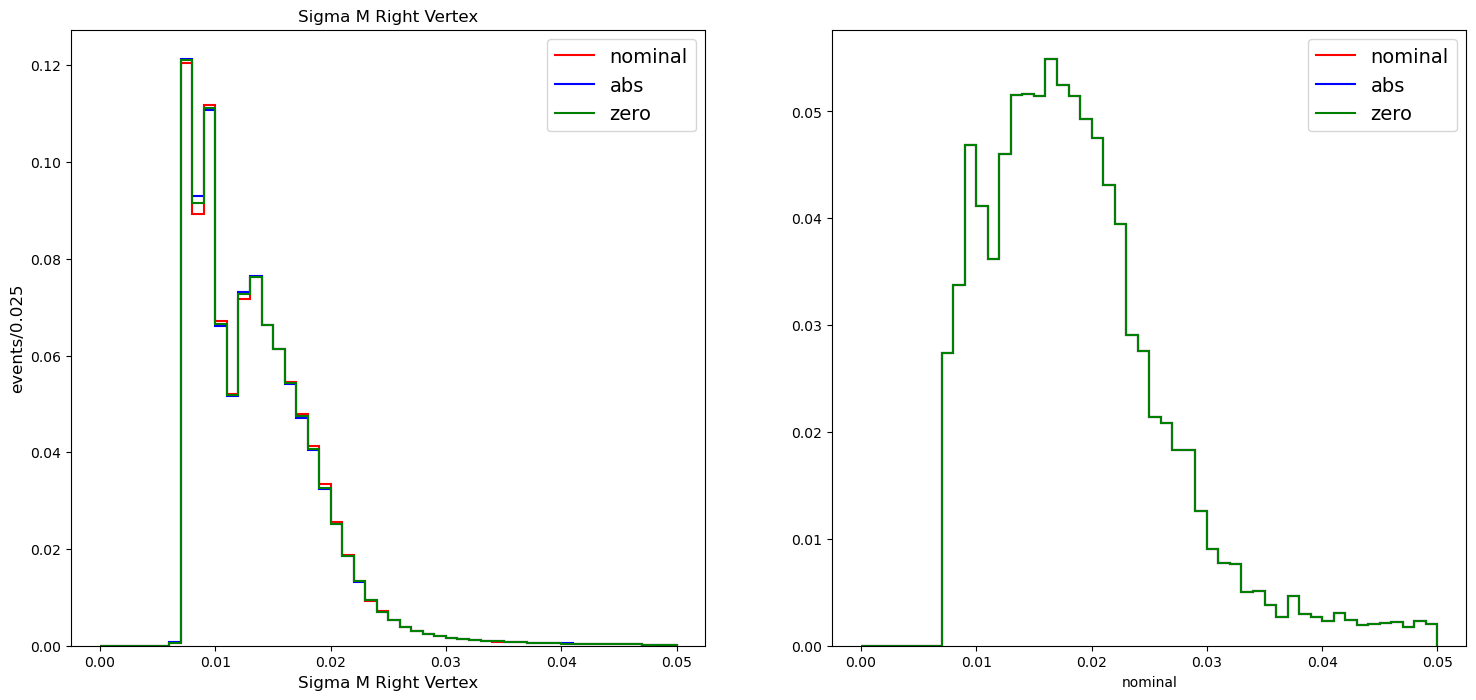

In [30]:
fig, axs = plt.subplots(1,2, figsize=(18, 8))

var = "sigmaMrv"
min_ = 0
max_ = 0.05
nbins = 50

h_lead_pt_mgg_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="nominal"))
h_lead_pt_mgg_sig_zero_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="zero"))
h_lead_pt_mgg_sig_abs_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="abs"))

h_lead_pt_mgg_bkg = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="nominal"))
h_lead_pt_mgg_bkg_zero_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="zero"))
h_lead_pt_mgg_bkg_abs_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="abs"))

h_lead_pt_mgg_sig.fill(ax = MC_events[var][(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)]/sum(MC_events.weight[(MC_events.proc_id > 0)]))
h_lead_pt_mgg_sig_zero_wgt.fill(ax = MC_events_zero[var][(MC_events_zero.proc_id > 0)], weight = MC_events_zero.weight[(MC_events_zero.proc_id > 0)]/sum(MC_events_zero.weight[(MC_events_zero.proc_id > 0)]))
h_lead_pt_mgg_sig_abs_wgt.fill(ax = MC_events_abs[var][(MC_events_abs.proc_id > 0)], weight = abs(MC_events_abs.weight[(MC_events_abs.proc_id > 0)])/sum(MC_events_abs.weight[(MC_events_abs.proc_id > 0)]))

h_lead_pt_mgg_bkg.fill(ax = MC_events[var][(MC_events.proc_id < 0)], weight = MC_events.weight[(MC_events.proc_id < 0)]/sum(MC_events.weight[(MC_events.proc_id < 0)]))
h_lead_pt_mgg_bkg_zero_wgt.fill(ax = MC_events_zero[var][(MC_events_zero.proc_id < 0)], weight = MC_events_zero.weight[(MC_events_zero.proc_id < 0)]/sum(MC_events_zero.weight[(MC_events_zero.proc_id < 0)]))
h_lead_pt_mgg_bkg_abs_wgt.fill(ax = MC_events_abs[var][(MC_events_abs.proc_id < 0)], weight = abs(MC_events_abs.weight[(MC_events_abs.proc_id < 0)])/sum(MC_events_abs.weight[(MC_events_abs.proc_id < 0)]))

h_lead_pt_mgg_sig.project("ax").plot(ax=axs[0], color="red", label="nominal")
h_lead_pt_mgg_sig_abs_wgt.project("ax").plot(ax=axs[0], color="blue", label="abs")
h_lead_pt_mgg_sig_zero_wgt.project("ax").plot(ax=axs[0], color="green", label="zero")

h_lead_pt_mgg_bkg.project("ax").plot(ax=axs[1], color="red", label="nominal")
h_lead_pt_mgg_bkg_abs_wgt.project("ax").plot(ax=axs[1], color="blue", label="abs")
h_lead_pt_mgg_bkg_zero_wgt.project("ax").plot(ax=axs[1], color="green", label="zero")

axs[0].legend(prop={'size': 14})
axs[0].set_ylabel('events/0.025', fontsize=12)
axs[0].set_xlabel('Sigma M Right Vertex', fontsize=12)
axs[0].set_title('Sigma M Right Vertex', fontsize=12)
axs[1].legend(prop={'size': 14})

plt.plot()
plt.show()

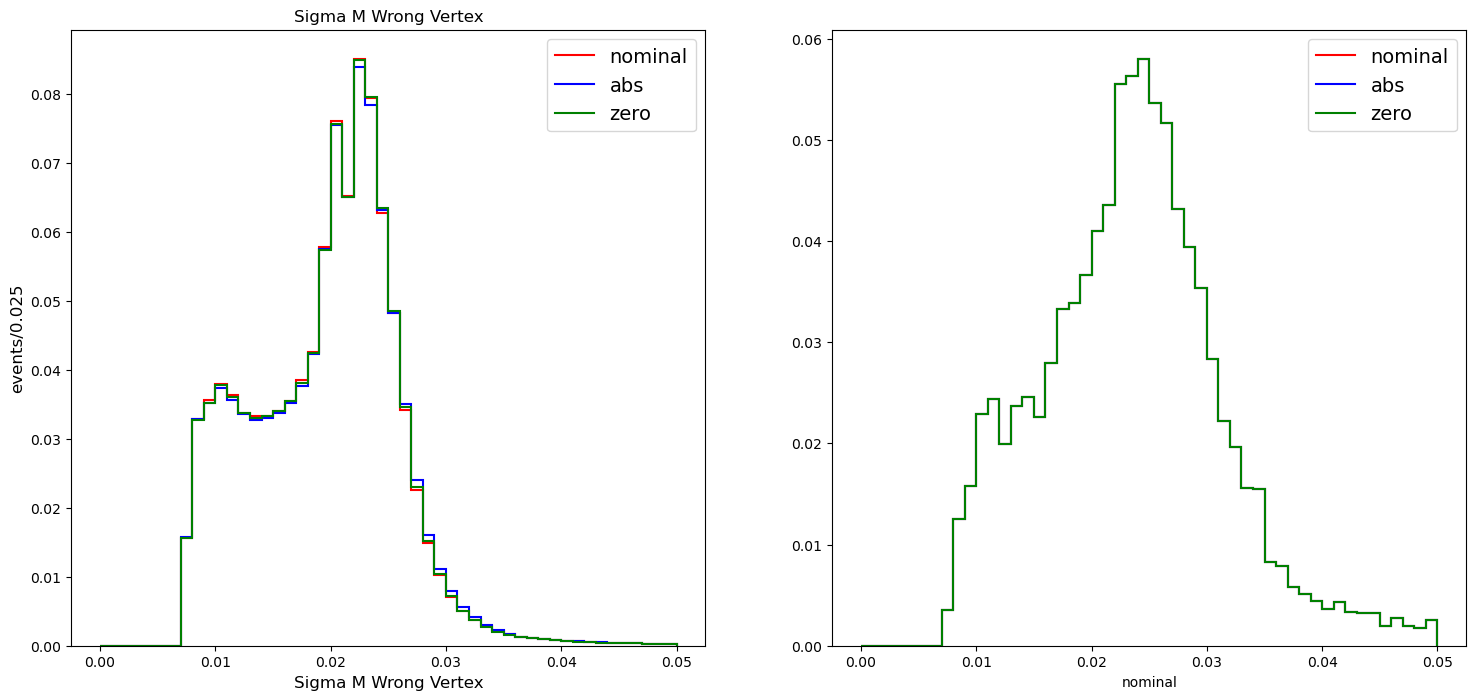

In [60]:
fig, axs = plt.subplots(1,2, figsize=(18, 8))

var = "sigmaMwv"
min_ = 0
max_ = 0.05
nbins = 50

h_lead_pt_mgg_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="nominal"))
h_lead_pt_mgg_sig_zero_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="zero"))
h_lead_pt_mgg_sig_abs_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="abs"))

h_lead_pt_mgg_bkg = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="nominal"))
h_lead_pt_mgg_bkg_zero_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="zero"))
h_lead_pt_mgg_bkg_abs_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="abs"))

h_lead_pt_mgg_sig.fill(ax = MC_events[var][(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)]/sum(MC_events.weight[(MC_events.proc_id > 0)]))
h_lead_pt_mgg_sig_zero_wgt.fill(ax = MC_events_zero[var][(MC_events_zero.proc_id > 0)], weight = MC_events_zero.weight[(MC_events_zero.proc_id > 0)]/sum(MC_events_zero.weight[(MC_events_zero.proc_id > 0)]) * zero_to_nominal.to_evaluator().evaluate(MC_events_zero["LeadPhoton_pt_mgg"][signal_cut], MC_events_zero["SubleadPhoton_pt_mgg"][signal_cut]))
h_lead_pt_mgg_sig_abs_wgt.fill(ax = MC_events_abs[var][(MC_events_abs.proc_id > 0)], weight = abs(MC_events_abs.weight[(MC_events_abs.proc_id > 0)])/sum(MC_events_abs.weight[(MC_events_abs.proc_id > 0)]))

h_lead_pt_mgg_bkg.fill(ax = MC_events[var][(MC_events.proc_id < 0)], weight = MC_events.weight[(MC_events.proc_id < 0)]/sum(MC_events.weight[(MC_events.proc_id < 0)]))
h_lead_pt_mgg_bkg_zero_wgt.fill(ax = MC_events_zero[var][(MC_events_zero.proc_id < 0)], weight = MC_events_zero.weight[(MC_events_zero.proc_id < 0)]/sum(MC_events_zero.weight[(MC_events_zero.proc_id < 0)]))
h_lead_pt_mgg_bkg_abs_wgt.fill(ax = MC_events_abs[var][(MC_events_abs.proc_id < 0)], weight = abs(MC_events_abs.weight[(MC_events_abs.proc_id < 0)])/sum(MC_events_abs.weight[(MC_events_abs.proc_id < 0)]))

h_lead_pt_mgg_sig.project("ax").plot(ax=axs[0], color="red", label="nominal")
h_lead_pt_mgg_sig_abs_wgt.project("ax").plot(ax=axs[0], color="blue", label="abs")
h_lead_pt_mgg_sig_zero_wgt.project("ax").plot(ax=axs[0], color="green", label="zero")

h_lead_pt_mgg_bkg.project("ax").plot(ax=axs[1], color="red", label="nominal")
h_lead_pt_mgg_bkg_abs_wgt.project("ax").plot(ax=axs[1], color="blue", label="abs")
h_lead_pt_mgg_bkg_zero_wgt.project("ax").plot(ax=axs[1], color="green", label="zero")

axs[0].legend(prop={'size': 14})
axs[0].set_ylabel('events/0.025', fontsize=12)
axs[0].set_xlabel('Sigma M Wrong Vertex', fontsize=12)
axs[0].set_title('Sigma M Wrong Vertex', fontsize=12)
axs[1].legend(prop={'size': 14})

plt.plot()
plt.show()

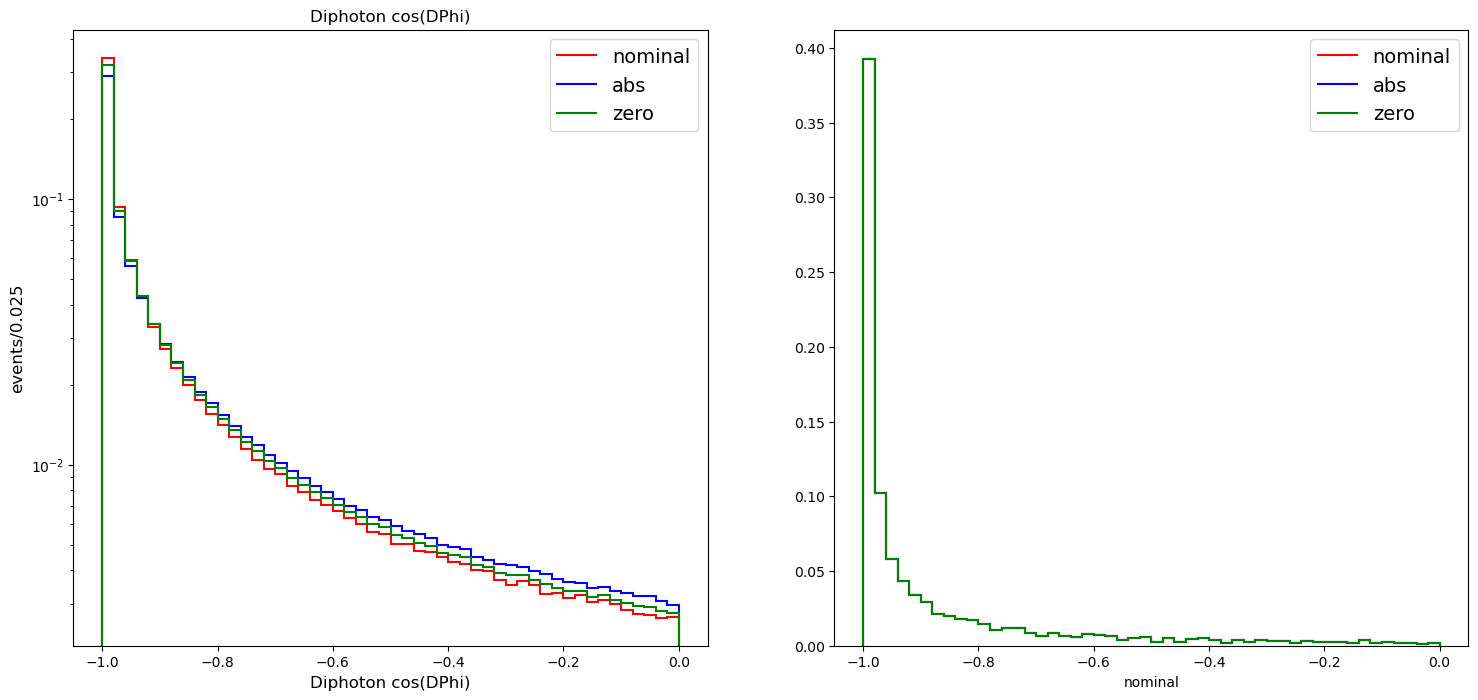

In [59]:
fig, axs = plt.subplots(1,2, figsize=(18, 8))

var = "Diphoton_cos_dPhi"
min_ = -1
max_ = 0
nbins = 50

h_lead_pt_mgg_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="nominal"))
h_lead_pt_mgg_sig_zero_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="zero"))
h_lead_pt_mgg_sig_abs_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="abs"))

h_lead_pt_mgg_bkg = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="nominal"))
h_lead_pt_mgg_bkg_zero_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="zero"))
h_lead_pt_mgg_bkg_abs_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="abs"))

h_lead_pt_mgg_sig.fill(ax = MC_events[var][(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)]/sum(MC_events.weight[(MC_events.proc_id > 0)]))
h_lead_pt_mgg_sig_zero_wgt.fill(ax = MC_events_zero[var][(MC_events_zero.proc_id > 0)], weight = MC_events_zero.weight[(MC_events_zero.proc_id > 0)]/sum(MC_events_zero.weight[(MC_events_zero.proc_id > 0)]) * zero_to_nominal.to_evaluator().evaluate(MC_events_zero["LeadPhoton_pt_mgg"][signal_cut], MC_events_zero["SubleadPhoton_pt_mgg"][signal_cut]))
h_lead_pt_mgg_sig_abs_wgt.fill(ax = MC_events_abs[var][(MC_events_abs.proc_id > 0)], weight = abs(MC_events_abs.weight[(MC_events_abs.proc_id > 0)])/sum(MC_events_abs.weight[(MC_events_abs.proc_id > 0)]) * zero_to_nominal.to_evaluator().evaluate(MC_events_abs["LeadPhoton_pt_mgg"][signal_cut], MC_events_abs["SubleadPhoton_pt_mgg"][signal_cut]))

h_lead_pt_mgg_bkg.fill(ax = MC_events[var][(MC_events.proc_id < 0)], weight = MC_events.weight[(MC_events.proc_id < 0)]/sum(MC_events.weight[(MC_events.proc_id < 0)]))
h_lead_pt_mgg_bkg_zero_wgt.fill(ax = MC_events_zero[var][(MC_events_zero.proc_id < 0)], weight = MC_events_zero.weight[(MC_events_zero.proc_id < 0)]/sum(MC_events_zero.weight[(MC_events_zero.proc_id < 0)]))
h_lead_pt_mgg_bkg_abs_wgt.fill(ax = MC_events_abs[var][(MC_events_abs.proc_id < 0)], weight = abs(MC_events_abs.weight[(MC_events_abs.proc_id < 0)])/sum(MC_events_abs.weight[(MC_events_abs.proc_id < 0)]))

h_lead_pt_mgg_sig.project("ax").plot(ax=axs[0], color="red", label="nominal")
h_lead_pt_mgg_sig_abs_wgt.project("ax").plot(ax=axs[0], color="blue", label="abs")
h_lead_pt_mgg_sig_zero_wgt.project("ax").plot(ax=axs[0], color="green", label="zero")

h_lead_pt_mgg_bkg.project("ax").plot(ax=axs[1], color="red", label="nominal")
h_lead_pt_mgg_bkg_abs_wgt.project("ax").plot(ax=axs[1], color="blue", label="abs")
h_lead_pt_mgg_bkg_zero_wgt.project("ax").plot(ax=axs[1], color="green", label="zero")

axs[0].legend(prop={'size': 14})
axs[0].set_ylabel('events/0.025', fontsize=12)
axs[0].set_yscale('log')
axs[0].set_xlabel('Diphoton cos(DPhi)', fontsize=12)
axs[0].set_title('Diphoton cos(DPhi)', fontsize=12)
axs[1].legend(prop={'size': 14})

plt.plot()
plt.show()

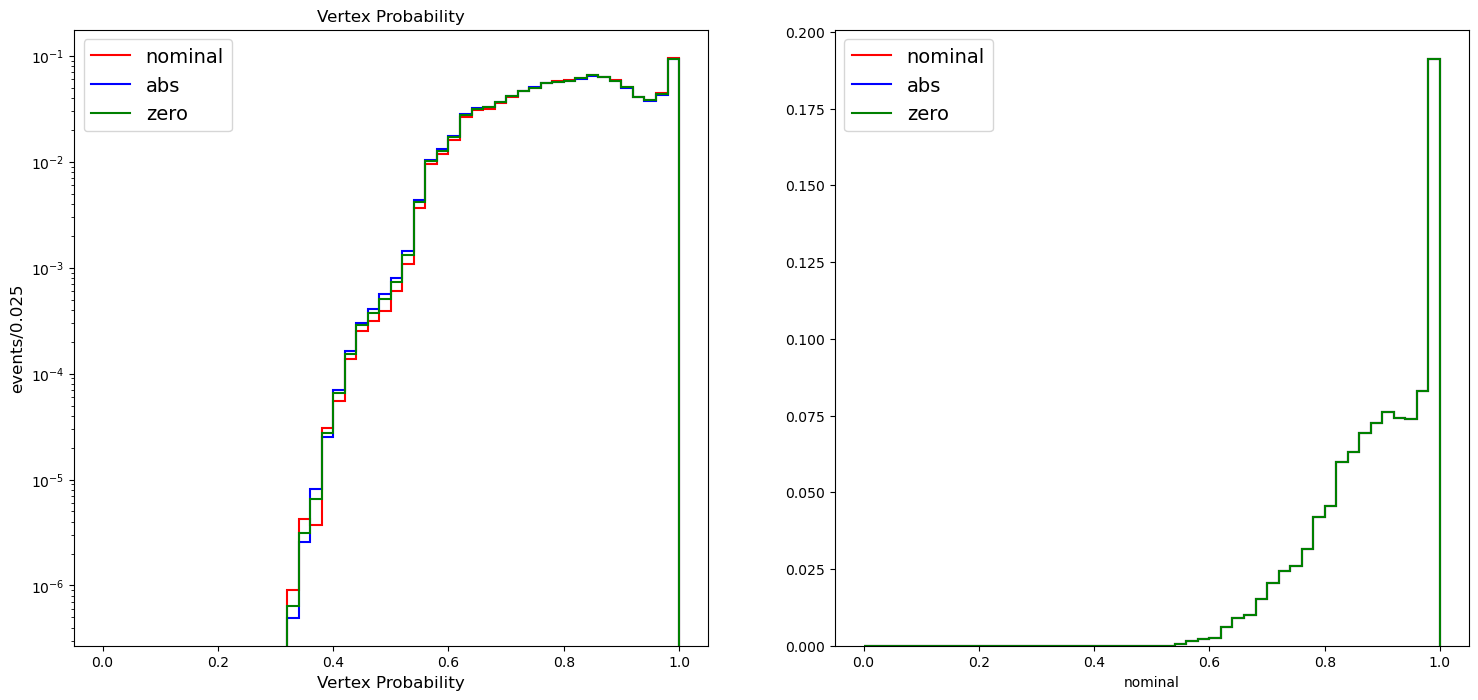

In [33]:
fig, axs = plt.subplots(1,2, figsize=(18, 8))

var = "vtxProb"
min_ = 0.
max_ = 1.
nbins = 50

h_lead_pt_mgg_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="nominal"))
h_lead_pt_mgg_sig_zero_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="zero"))
h_lead_pt_mgg_sig_abs_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="abs"))

h_lead_pt_mgg_bkg = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="nominal"))
h_lead_pt_mgg_bkg_zero_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="zero"))
h_lead_pt_mgg_bkg_abs_wgt = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "ax", label="abs"))

h_lead_pt_mgg_sig.fill(ax = MC_events[var][(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)]/sum(MC_events.weight[(MC_events.proc_id > 0)]))
h_lead_pt_mgg_sig_zero_wgt.fill(ax = MC_events_zero[var][(MC_events_zero.proc_id > 0)], weight = MC_events_zero.weight[(MC_events_zero.proc_id > 0)]/sum(MC_events_zero.weight[(MC_events_zero.proc_id > 0)]))
h_lead_pt_mgg_sig_abs_wgt.fill(ax = MC_events_abs[var][(MC_events_abs.proc_id > 0)], weight = abs(MC_events_abs.weight[(MC_events_abs.proc_id > 0)])/sum(MC_events_abs.weight[(MC_events_abs.proc_id > 0)]))

h_lead_pt_mgg_bkg.fill(ax = MC_events[var][(MC_events.proc_id < 0)], weight = MC_events.weight[(MC_events.proc_id < 0)]/sum(MC_events.weight[(MC_events.proc_id < 0)]))
h_lead_pt_mgg_bkg_zero_wgt.fill(ax = MC_events_zero[var][(MC_events_zero.proc_id < 0)], weight = MC_events_zero.weight[(MC_events_zero.proc_id < 0)]/sum(MC_events_zero.weight[(MC_events_zero.proc_id < 0)]))
h_lead_pt_mgg_bkg_abs_wgt.fill(ax = MC_events_abs[var][(MC_events_abs.proc_id < 0)], weight = abs(MC_events_abs.weight[(MC_events_abs.proc_id < 0)])/sum(MC_events_abs.weight[(MC_events_abs.proc_id < 0)]))

h_lead_pt_mgg_sig.project("ax").plot(ax=axs[0], color="red", label="nominal")
h_lead_pt_mgg_sig_abs_wgt.project("ax").plot(ax=axs[0], color="blue", label="abs")
h_lead_pt_mgg_sig_zero_wgt.project("ax").plot(ax=axs[0], color="green", label="zero")

h_lead_pt_mgg_bkg.project("ax").plot(ax=axs[1], color="red", label="nominal")
h_lead_pt_mgg_bkg_abs_wgt.project("ax").plot(ax=axs[1], color="blue", label="abs")
h_lead_pt_mgg_bkg_zero_wgt.project("ax").plot(ax=axs[1], color="green", label="zero")

axs[0].legend(prop={'size': 14})
axs[0].set_ylabel('events/0.025', fontsize=12)
axs[0].set_yscale('log')
axs[0].set_xlabel('Vertex Probability', fontsize=12)
axs[0].set_title('Vertex Probability', fontsize=12)
axs[1].legend(prop={'size': 14})

plt.plot()
plt.show()